Variables of filenames

In [1]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/inz/jupyter/'
fileName = directory + 'PlainTree2M_ml_DCM_12gev.root'
# fileName = directory + 'PlainTree10K_ml_DCM_12gev.root'
fileNameTest = directory + 'PlainTree1M_ml_URQMD_12gev.root'
# fileNameTest = directory + 'PlainTree10k_ml_DCM_12gev.root'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
from matplotlib.backends.backend_pdf import PdfPages
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from bayes_opt import BayesianOptimization
# from bayes_opt import SequentialDomainReductionTransformer

import gc, os
from enum import Enum

In [3]:
#CUTS USED FOR DATA CLEANING
#momentums cuts
pzLowerCut = 0
pUpperCut = 12
ptUpperCut = 2
m2LowerCut = -1
m2UpperCut = 2
#time
tUpperCut = 40
#pid codes of particles
class Pid(Enum):
    ELECTRON = 11
    # POSITRON = -11
    # ELECTRON = 11
    PROTON = 2212 
    # NEG_MUON = -13
    # POS_MUON = 13
    MUON = 13
    # NEG_PION = -211
    # POS_PION = 211 
    PION = 211
    # NEG_KAON = -321
    # POS_KAON = 321 
    KAON = 321
    BCKGR = 999
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 
    
def clean_df(df, info = 0):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #pz
    size_pz =  len(df['pz'])
    is_good_pz = (df['pz'] > pzLowerCut)
    percentage_pz = ( size_pz - len(df[is_good_pz]) ) / size_pz
    #p
    size_p =  len(df['p'])
    is_good_p = (df['p'] < pUpperCut)
    percentage_p = ( size_p - len(df[is_good_p]) ) / size_p
    #p
    size_pt =  len(df['pT'])
    is_good_pt = (df['pT'] < ptUpperCut)
    percentage_pt = ( size_pt - len(df[is_good_pt]) ) / size_pt
    # #t
    # size_t =  len(df['t'])
    # is_good_t = (df['t'] < tUpperCut)
    # percentage_t = ( size_t - len(df[is_good_t]) ) / size_t
    #mass2
    size_m2 =  len(df['mass2'])
    is_good_m2 = (df['mass2'] > m2LowerCut) & (df['mass2'] < m2UpperCut)
    percentage_m2 = ( size_m2 - len(df[is_good_m2]) ) / size_m2
    is_good_df = (is_good_pz) & (is_good_p) & (is_good_pt) & (is_good_m2) #& (is_good_t)
    if (info == 1):
        print('with the pz selection criteria we lose we loose ' + str(round(percentage_pz*100, 4)) + '% of entries')
        print('with the p selection criteria we lose we loose ' + str(round(percentage_p*100, 4)) + '% of entries')
        print('with the pT selection criteria we lose we loose ' + str(round(percentage_pt*100, 4)) + '% of entries')
        print('with the t selection criteria we lose we loose ' + str(round(percentage_t*100, 4)) + '% of entries')

    return df[is_good_df]
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )
def sigma(df:pd.DataFrame, pid, nsigma=1, info=False):
    mean = df[df['pid']==pid]['mass2'].mean()
    std = df[df['pid']==pid]['mass2'].std()
    out_sigma = (df['pid']==pid) & ((df['mass2'] < (mean-nsigma*std)) | (df['mass2'] > (mean+nsigma*std)))
    df1 = df[~ out_sigma]
    if info:
        df_len = len(df)
        df1_len = len(df1)
        print('we get rid of ' + str ( round( ( df_len - df1_len) / df_len *100, 2)) + ' % of pid = ' 
              + str(pid) + ' particle entries')
    return df1

def xgb_preds(df, probaProton, probaKaon, probaPion):
    #getting max field
    df['xgb_preds']=df[[0, 1, 2]].idxmax(axis = 1)
    #setting to bckgr if smaller than probability threshold
    proton = (df['xgb_preds'] == 0) & (df[0] < probaProton )
    pion   = (df['xgb_preds'] == 1) & (df[1] < probaKaon )
    kaon   = (df['xgb_preds'] == 2) & (df[2] < probaPion )
    df.loc[( proton | pion | kaon ), 'xgb_preds'] = 3
    return df

from collections import defaultdict
def remap_names(dataframe):
    return dataframe.pid.abs().map(defaultdict(lambda: 3, {Pid.PROTON.value : 0, Pid.KAON.value : 1,  Pid.PION.value : 2, Pid.ELECTRON.value : 2, Pid.MUON.value : 2}),na_action='ignore')#, Pid.ELECTRON.value : 2, , Pid.MUON.value : 2
 

In [4]:
import matplotlib as mpl
def sim_tof(df, pid):

    qp = df[df['pid']==pid]['q']*df[df['pid']==pid]['p']
    var_xaxis = qp
    mass2 = df[df['pid']==pid]['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [5]:
%%capture
#Shahid's library for importing roottrees
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

In [6]:
# We import three root files into our jupyter notebook
particles = tree_importer.tree_importer(fileName,'plain_tree',7)
particles.columns = particles.columns.str.replace('Complex_', '')
gc.collect()
particles.iloc[0:10,:]

,eta,mass,mass2,p,pT,phi,px,py,pz,rapidity,pid,q
0,2.500318,0.938272,0.887791,5.464226,0.890780,-1.681210,-0.098154,-0.885356,5.391130,2.134439,2212.0,1.0
1,1.806927,0.139570,-0.011916,2.865169,0.915995,-2.710099,-0.832037,-0.383095,2.714801,1.796060,-211.0,-1.0
2,2.115173,0.139570,-0.009863,1.882905,0.447691,-2.514619,-0.362543,-0.262659,1.828908,2.070187,211.0,1.0
3,2.097679,0.139570,0.008711,1.499275,0.362582,-2.560894,-0.303147,-0.198916,1.454771,2.030786,-211.0,-1.0
4,2.398703,0.139570,0.017425,1.294498,0.233248,-2.376918,-0.168314,-0.161478,1.273311,2.248595,211.0,1.0
5,2.667830,0.938272,-0.237758,13.857271,1.914243,-2.004751,-0.804867,-1.736811,13.724418,2.561323,2212.0,1.0
6,2.134996,0.493677,0.278050,3.193019,0.744705,-0.563221,0.629678,-0.397607,3.104961,1.958869,321.0,1.0
7,2.228435,0.139570,0.013302,1.916363,0.408040,-2.585814,-0.346626,-0.215284,1.872419,2.174451,211.0,1.0
8,2.670892,0.938272,0.796354,4.072494,0.560869,-0.887893,0.353935,-0.435091,4.033687,2.016658,2212.0,1.0
9,1.703533,0.938272,0.868623,2.257667,0.795603,-2.886779,-0.769913,-0.200544,2.112836,1.309662,2212.0,1.0


In [7]:

particles['pid'] = remap_names(particles)
#dropping bckgr value for training
particles = particles[particles['pid'] != 3]
gc.collect()
print('number of particles before downsampling : ' + str(len(particles)))

#downsampling the data

particles = downsample(particles, 'pid')
print('number of particles per class after downsampling : ' + str(len(particles)/3))
particles.iloc[0:10,:]
#cleaning and 1sigma region selection
# particles = clean_df(particles)
# for particle in particles['pid'].unique(): 
#     particles = sigma(particles, particle, 1, True)

number of particles before downsampling : 138907777
number of particles per class after downsampling : 3735746.0


,eta,mass,mass2,p,pT,phi,px,py,pz,rapidity,pid,q
0,2.384911,0.938272,0.847546,1.459815,0.266628,-2.439721,-0.203606,-0.172148,1.435259,1.178808,0,1.0
1,2.162041,0.938272,0.867355,1.638529,0.372226,0.038419,0.371952,0.014297,1.595690,1.238772,0,1.0
2,2.027587,0.938272,0.916536,2.182454,0.564862,3.037547,-0.561808,0.058665,2.108088,1.409525,0,1.0
3,2.260082,0.938272,0.831529,3.739105,0.771887,1.602560,-0.024514,0.771497,3.658565,1.821991,0,1.0
4,2.697351,0.938272,0.845677,3.148276,0.422367,-1.300370,0.112832,-0.407017,3.119815,1.828525,0,1.0
5,2.296809,0.938272,0.721040,5.247324,1.044972,-2.782091,-0.978169,-0.367629,5.142221,2.009172,0,1.0
6,2.042819,0.938272,0.834753,2.617641,0.667597,-0.286622,0.640362,-0.188739,2.531079,1.528832,0,1.0
7,2.429313,0.938272,0.832601,5.140262,0.898712,0.721608,0.674703,0.593683,5.061088,2.069029,0,1.0
8,2.028707,0.938272,1.363374,7.887436,2.039216,2.197200,-1.195459,1.652053,7.619268,1.936272,0,1.0
9,3.070516,0.938272,0.880971,3.905572,0.361636,1.249786,0.114105,0.343162,3.888793,2.062020,0,1.0


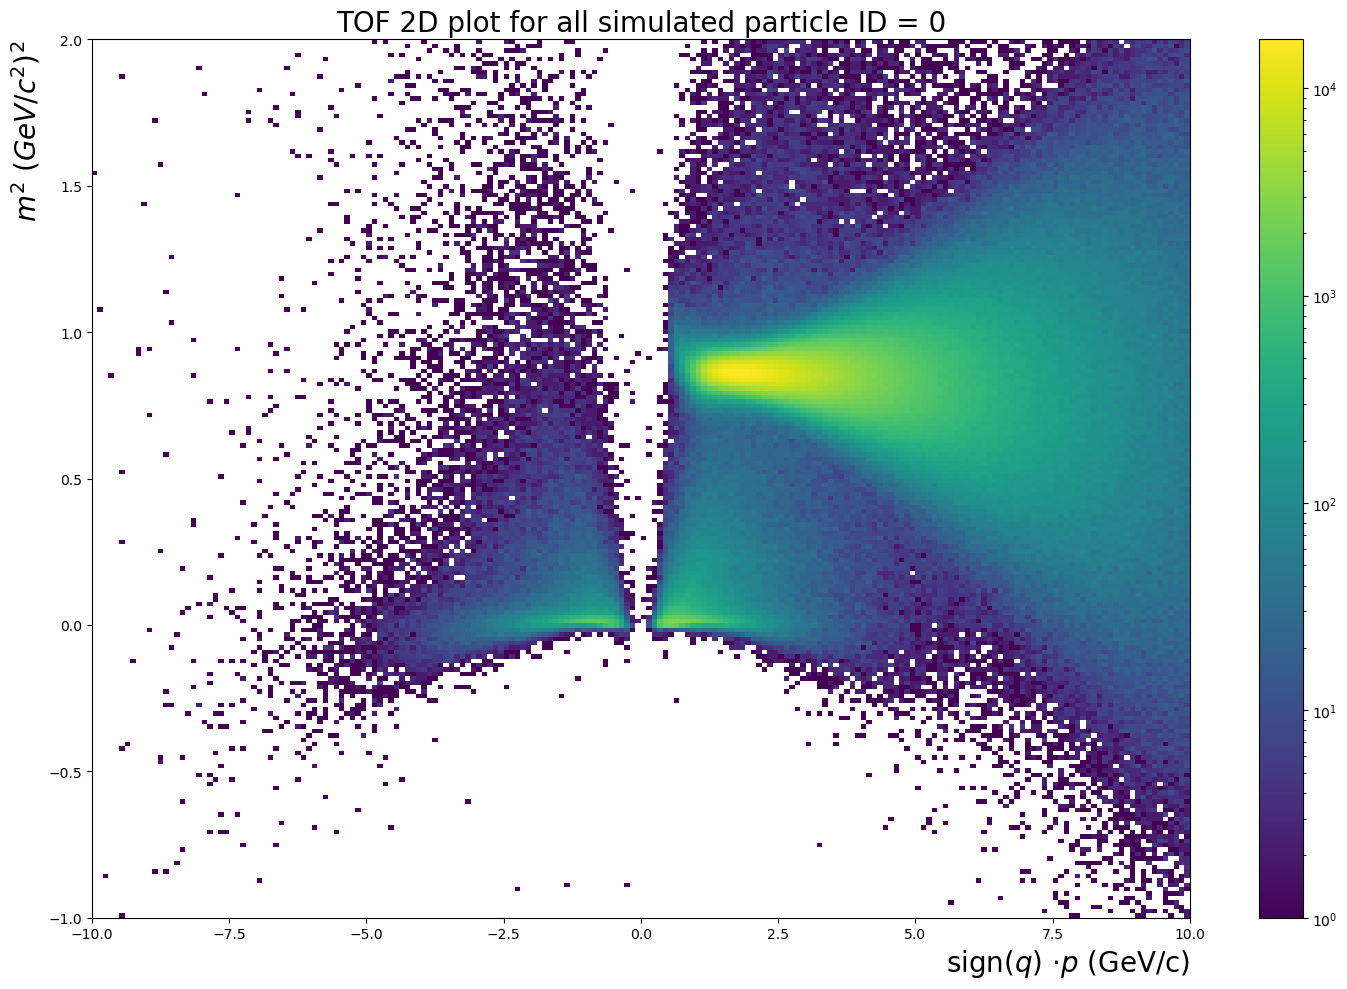

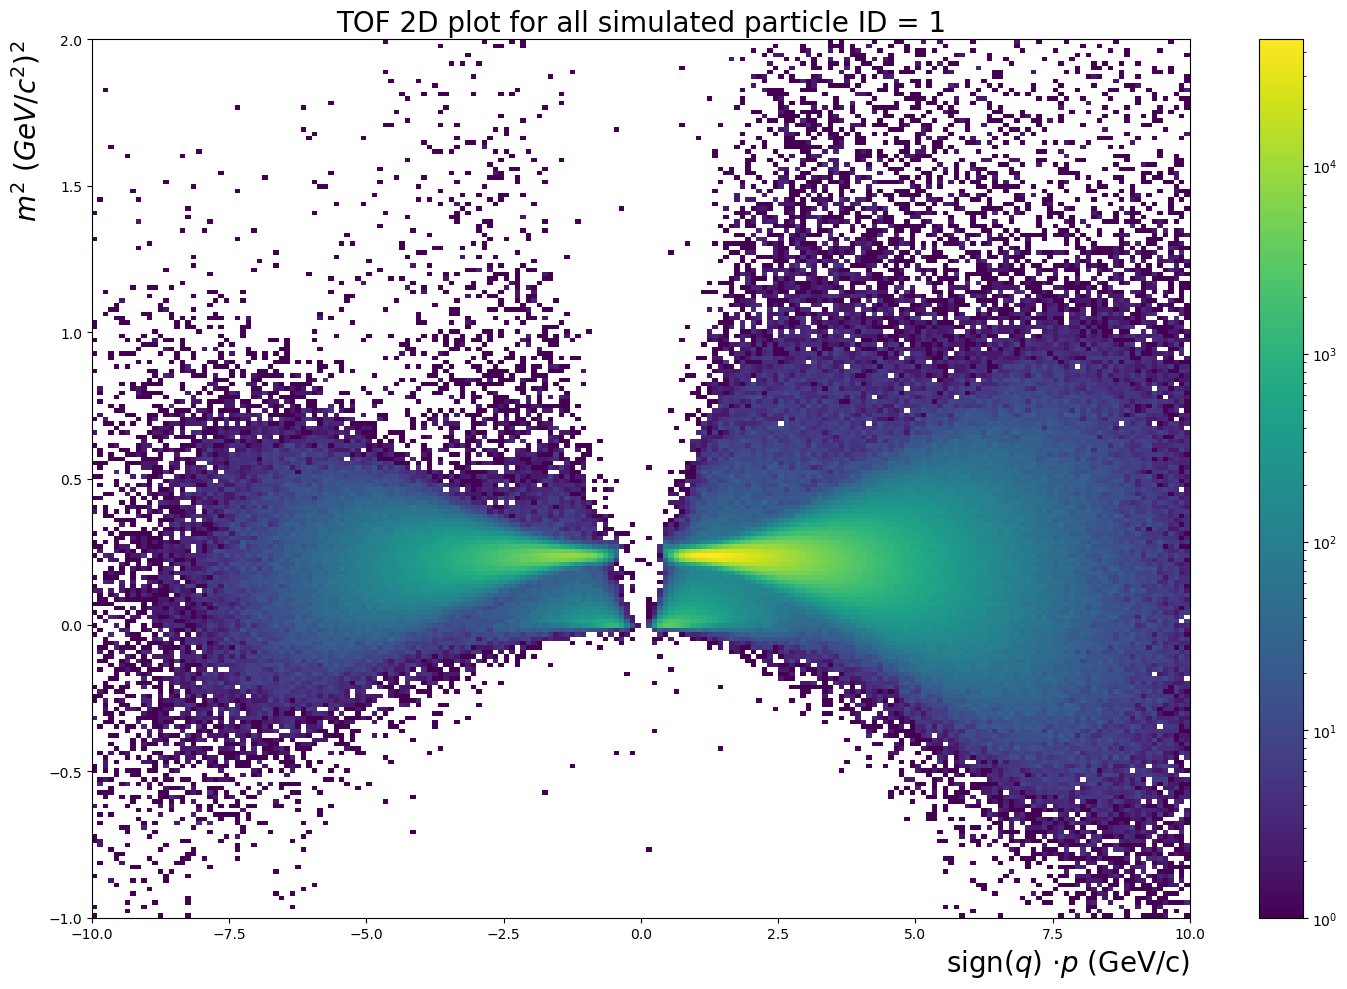

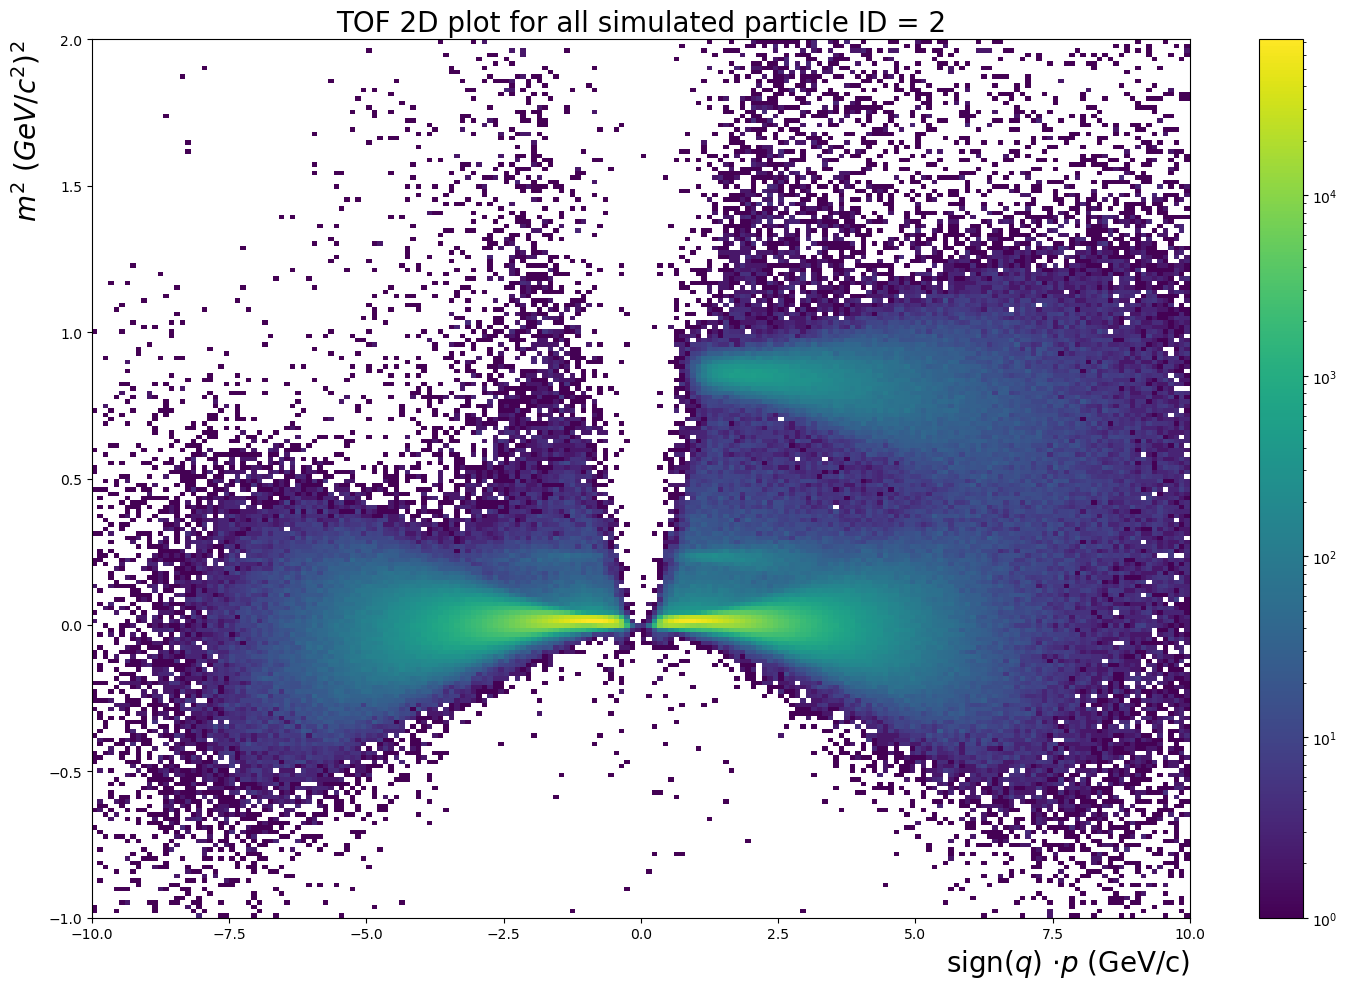

In [8]:
for i in range(3):
    sim_tof(particles, i)

we get rid of 2.67 % of pid = 0 particle entries
we get rid of 3.0 % of pid = 1 particle entries
we get rid of 1.32 % of pid = 2 particle entries


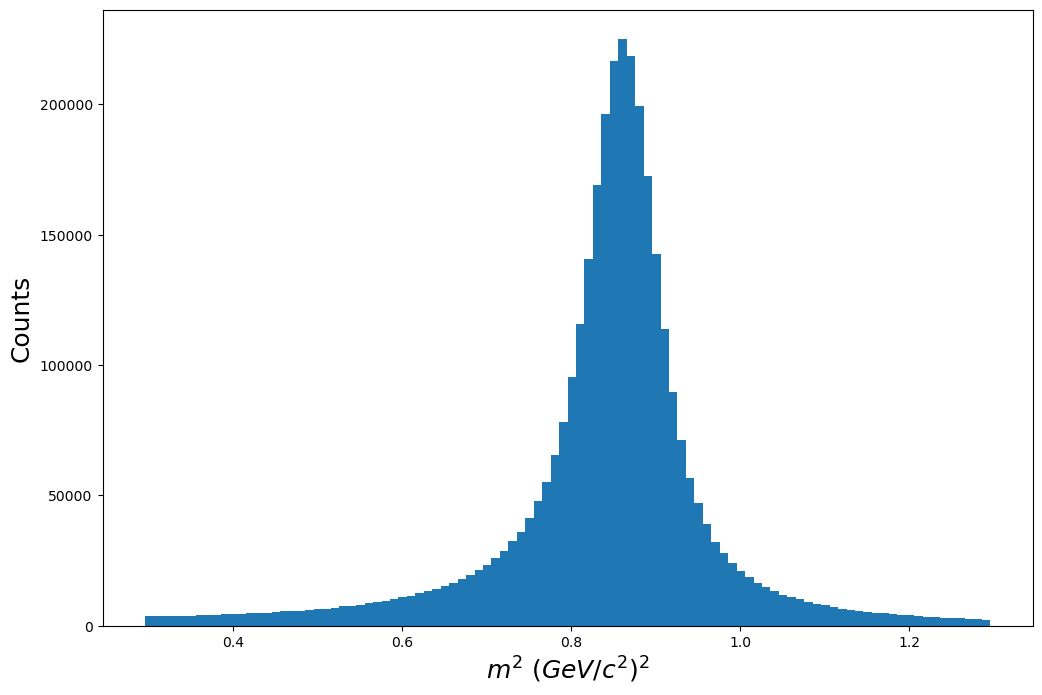

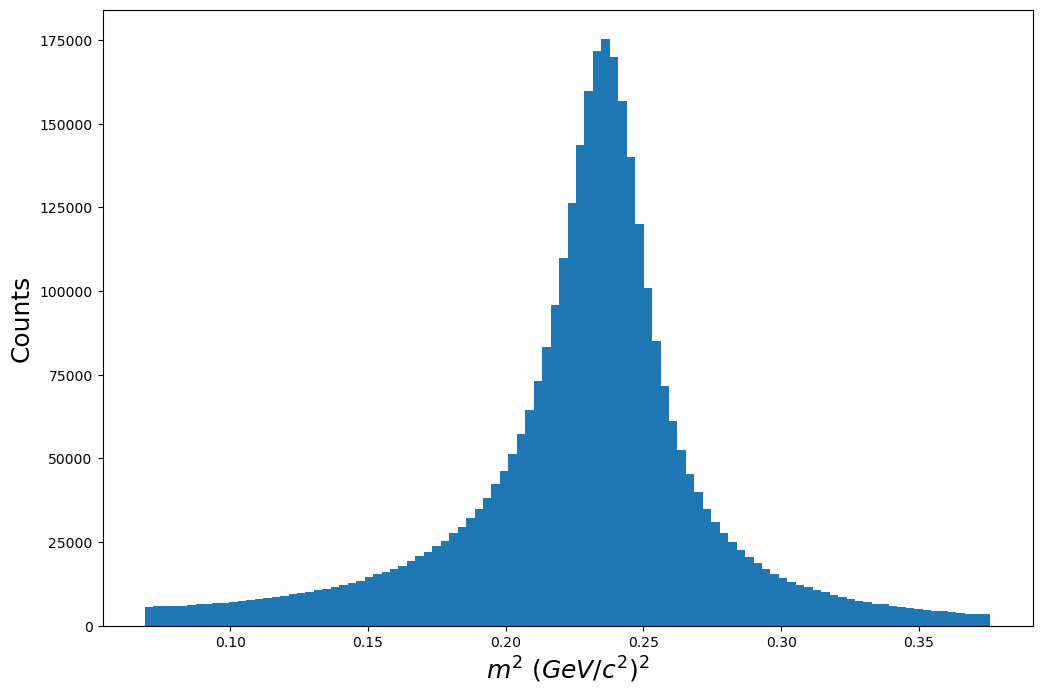

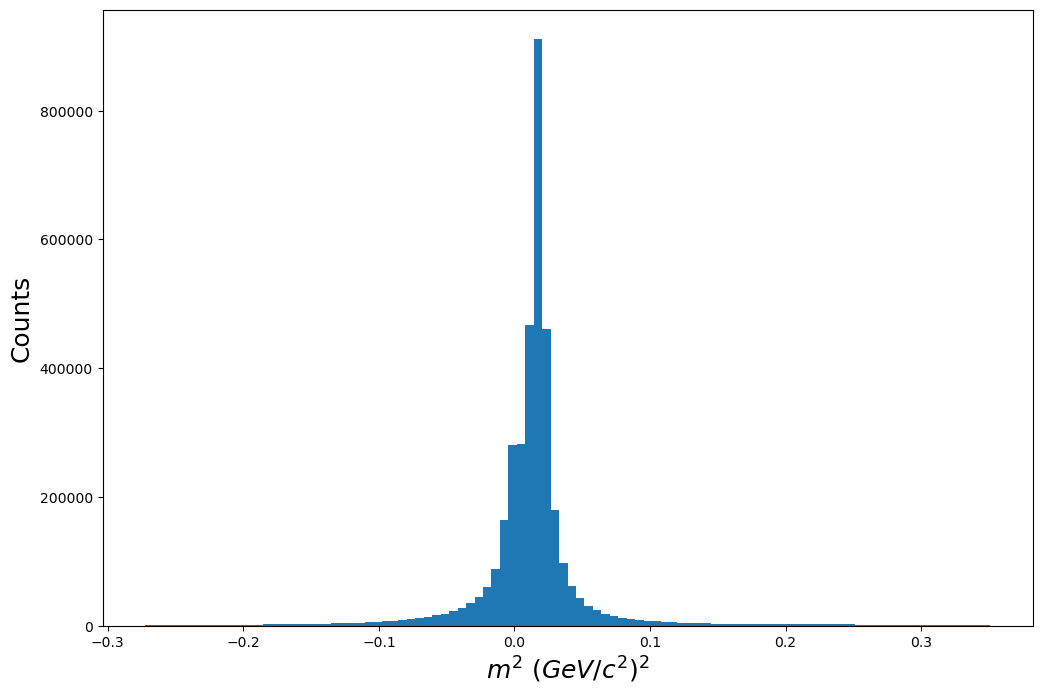

In [9]:
#cleaning and 1sigma region selection
particles = clean_df(particles)
#manual sigma selection for each particle    
particles = sigma(particles, 0, 2, True)
particles = sigma(particles, 1, 1.5, True)
particles = sigma(particles, 2, 2, True)
#we check sigma selection
for pid in particles['pid'].unique():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(particles[particles['pid'] == pid]['mass2'], bins=100)
    ax.set_xlabel(r'$m^2$ $(GeV/c^2)^2$',fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    # ax.set_yscale('log')
    
    plt.show()

In [10]:
'''after cleaning'''

'after cleaning'

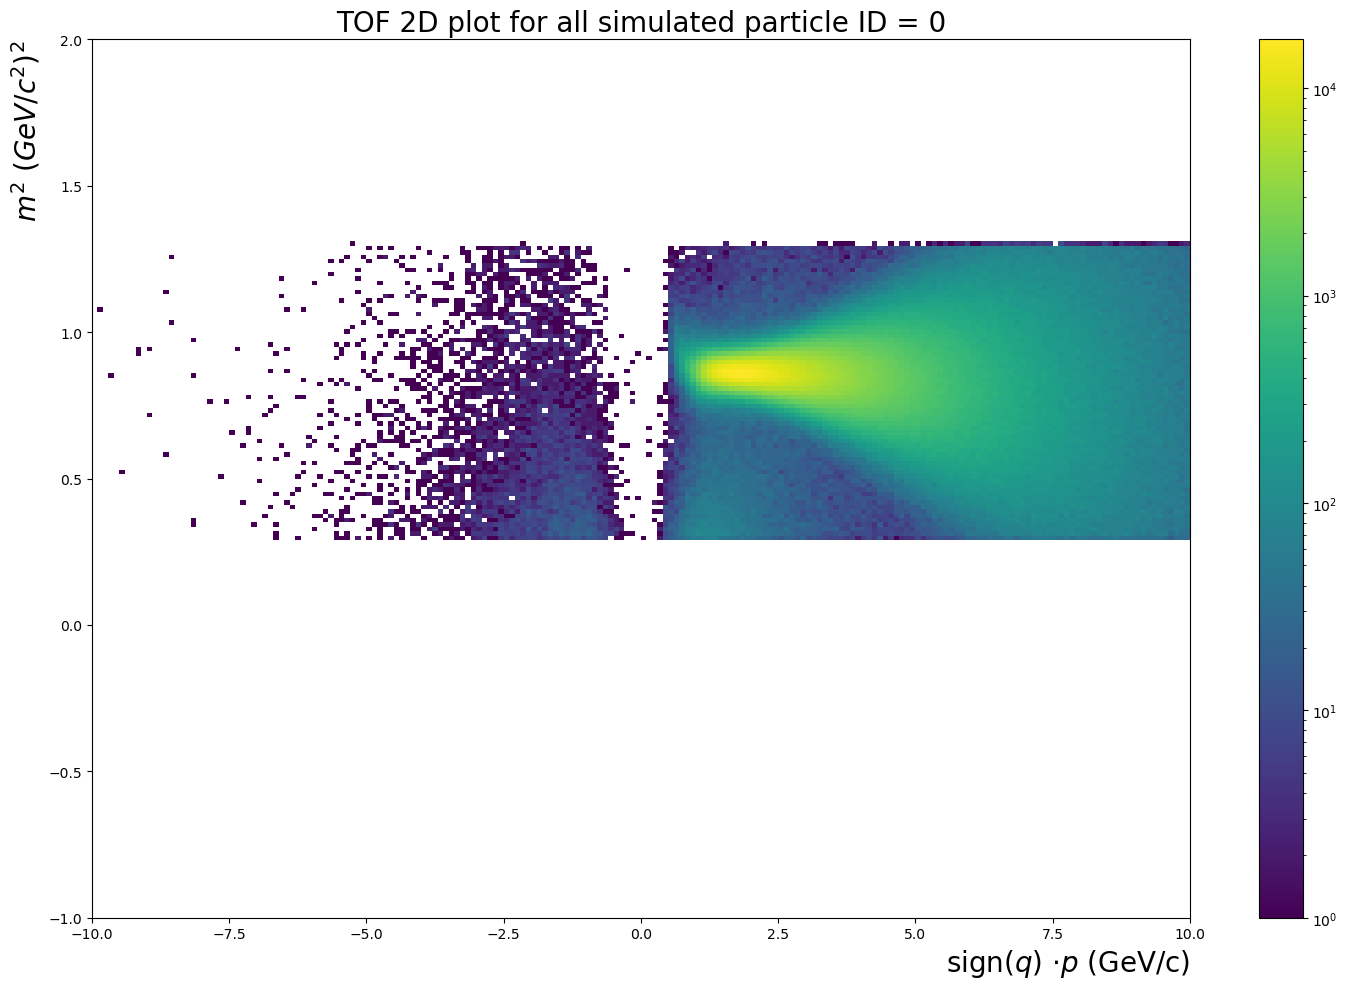

In [10]:
sim_tof(particles, 0)

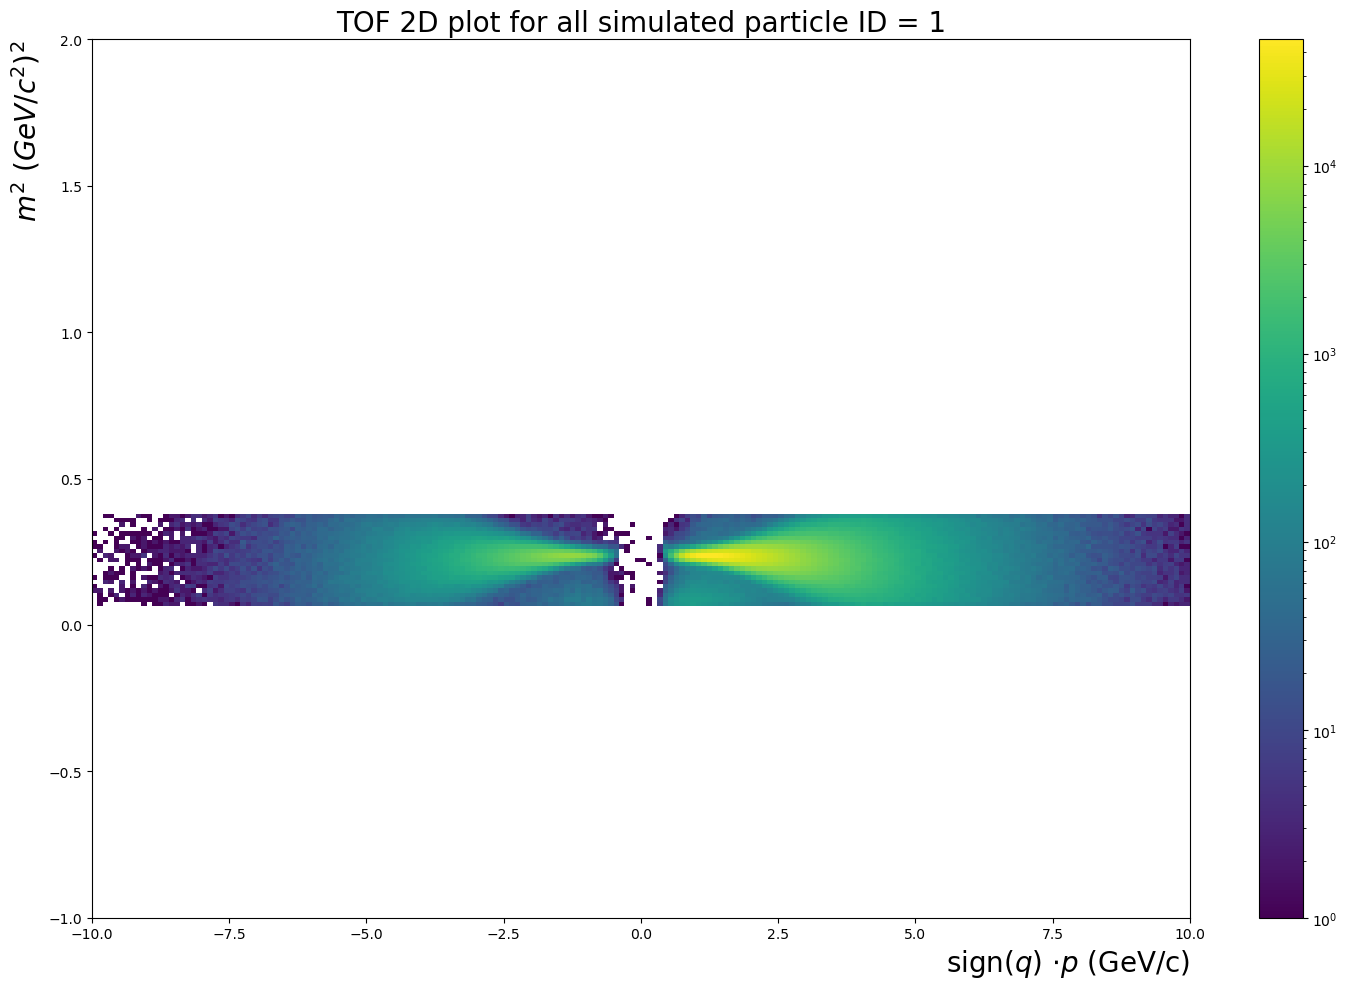

In [11]:
sim_tof(particles, 1)

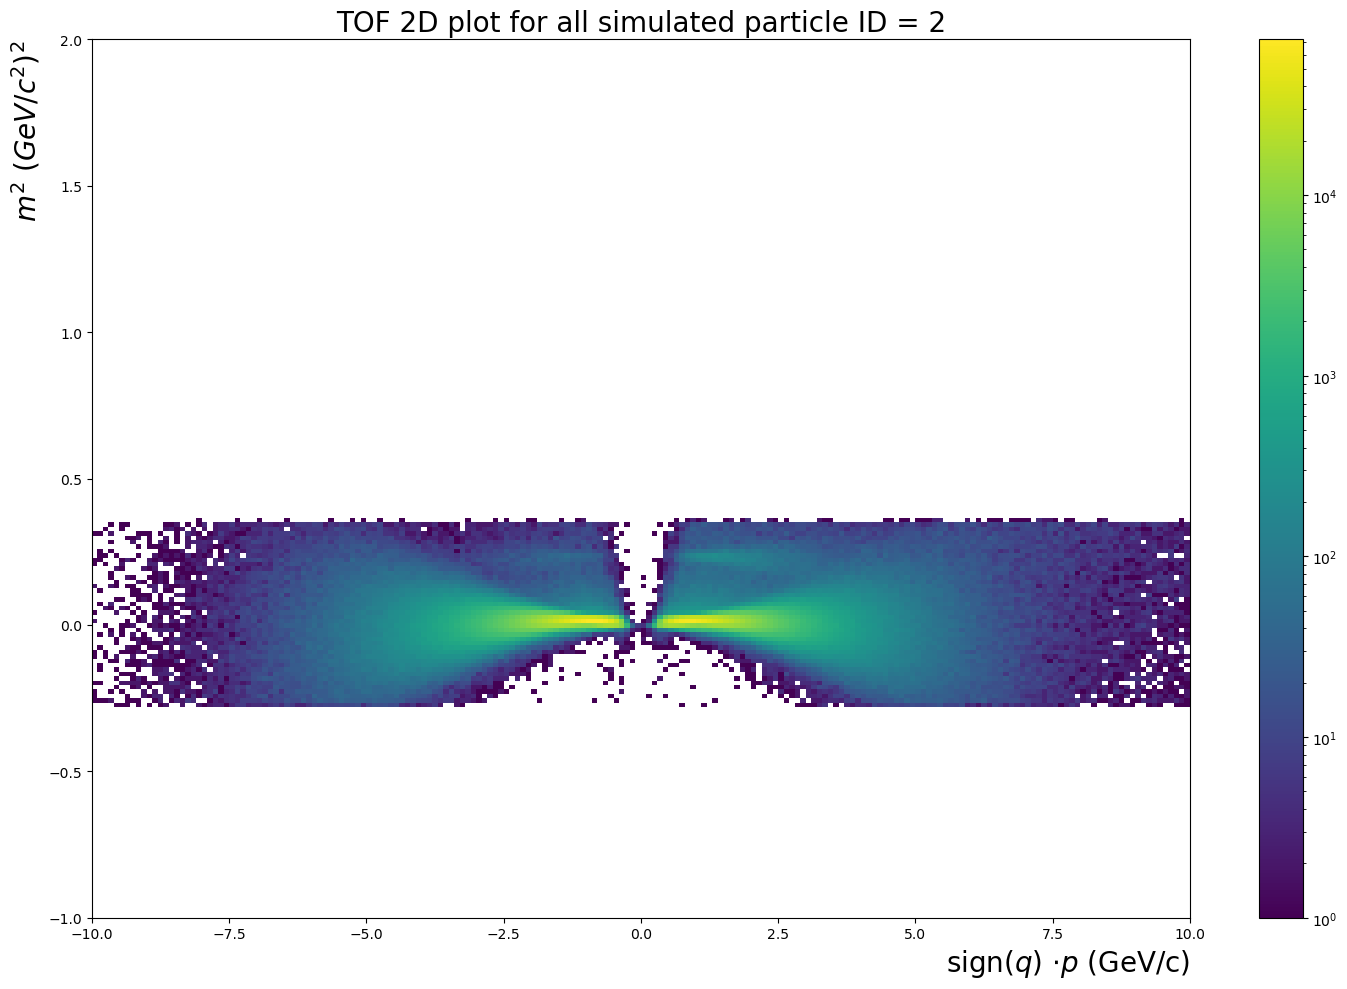

In [12]:
sim_tof(particles, 2)

In [13]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
params = ['mass2', 'p', 'pT', 'eta']
x = particles[params].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(particles['pid'], dtype='int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=324)
del particles, x, y

#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train)
# dtest1=xgb.DMatrix(x_test, label = y_test)
# del x_test
gc.collect()

33259

In [15]:
def bo_tune_xgb(max_depth, gamma, alpha, eta, subsample, n_estimators):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'eta':eta,
              'subsample': subsample,
              'n_estimators': n_estimators,
              # 'eta': 0.3, - it is now same as the learning rate
              'num_class':np.unique(dtrain.get_label()).shape[0],
              'objective':'multi:softprob', 
              'eval_metric': 'mlogloss',
              # 'tree_method':'hist', 'nthread' : 7
             }
    cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=5)
    return (1 -  cv_result['test-mlogloss-mean'].iloc[-1])
    
# bounds_transformer = SequentialDomainReductionTransformer()
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 14),
                                             'alpha': (0,10),
                                             'gamma': (0, 4),
                                            'n_estimators': (400, 1200),
                                             'subsample': (0.6, 0.9),
                                             'eta':(0.1, 0.8), #learning rate
                                            })



In [16]:
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   |   alpha   |    eta    |   gamma   | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
[22:24:38] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:24:47] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:24:56] WAR

KeyboardInterrupt: 

In [17]:
print(xgb_bo.max['params'])

{'alpha': 5.929064997548361, 'eta': 0.7633284695998168, 'gamma': 3.752469995575164, 'max_depth': 10.274285922466722, 'n_estimators': 803.3630762263606, 'subsample': 0.6063168560029321}


In [14]:
# max_param = xgb_bo.max['params']
max_param = {'alpha': 5.929064997548361, 'eta': 0.7633284695998168, 'gamma': 3.752469995575164, 'max_depth': 10.274285922466722, 
             'n_estimators': 803.3630762263606, 'subsample': 0.6063168560029321}
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'eta': max_param['eta'], 'n_estimators': int(round(max_param['n_estimators'], 0)),
        'max_depth': int(round(max_param['max_depth'],0)), 'num_class':np.unique(dtrain.get_label()).shape[0],
        'objective':'multi:softprob','eval_metric': 'mlogloss', 'subsample': max_param['subsample'], 
        'tree_method':'hist','nthread' : 7}

#Fit/train on training data
bst = xgb.XGBClassifier(**param, use_label_encoder=False).fit(x_train, y_train)

#predicitions on training set
bst_train= pd.DataFrame(data=bst.predict_proba(x_train))
y_train=y_train.set_index(np.arange(0,bst_train.shape[0]))
bst_train['pid']=y_train['pid']

bst_test = pd.DataFrame(data=bst.predict_proba(x_test))
bst_test['xgb_preds']=bst_test.iloc[:,0:(len(bst_test.columns)-1)].idxmax(axis = 1)
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['pid']=y_test['pid']
del x_train, x_test, y_train, y_test, dtrain
gc.collect()

0

## Another set
We also select the selected variables from the 10k events data set

In [15]:
# We import three root files into our jupyter notebook
particlesTest = tree_importer.tree_importer(fileNameTest,'plain_tree',7)
particlesTest.columns = particlesTest.columns.str.replace('Complex_', '')
particlesTest = clean_df(particlesTest)
gc.collect()
#changign to the same pid as in training
particlesTest['pid'] = remap_names(particlesTest)
particlesTest.iloc[0:10,:]

,eta,mass,mass2,p,pT,phi,px,py,pz,rapidity,pid,q
0,2.795109,0.139570,0.044752,3.360802,0.409217,-1.931746,-0.144520,-0.382848,3.335796,2.740521,2,-1.0
1,2.862100,0.493677,0.248146,2.920601,0.332732,-1.740885,-0.056321,-0.327931,2.901586,2.287393,1,1.0
2,2.025051,0.938272,0.904669,2.650691,0.687733,-2.986821,-0.679512,-0.106017,2.559919,1.529873,0,1.0
3,1.962085,0.938272,0.842410,3.123042,0.860970,-0.086505,0.857751,-0.074385,3.002019,1.592940,0,1.0
4,2.162448,0.139570,-0.004009,2.821904,0.640801,0.066599,0.639381,0.042645,2.748184,2.139893,2,-1.0
5,3.121445,0.938272,1.108287,6.939540,0.610784,1.233429,0.202172,0.576353,6.912608,2.520050,0,1.0
6,2.217318,0.938272,0.834824,2.472587,0.532222,2.700255,-0.481225,0.227338,2.414628,1.545454,0,1.0
7,2.156020,0.938272,0.882386,5.610508,1.282038,0.950416,0.745306,1.043139,5.462068,1.948566,0,1.0
8,2.211525,0.139570,0.015155,1.712385,0.370680,1.318592,0.092499,0.358953,1.671783,2.146911,2,1.0
9,1.950903,0.139570,0.015053,1.949115,0.543142,2.232159,-0.333594,0.428624,1.871910,1.920236,2,-1.0


In [16]:
x_whole = particlesTest[params].copy()
y_whole = pd.DataFrame(particlesTest['pid'], dtype='int')

whole_test= pd.DataFrame(data=bst.predict_proba(x_whole))
y_whole=y_whole.set_index(np.arange(0,whole_test.shape[0]))

whole_test['pid']=y_whole['pid']
gc.collect()

9

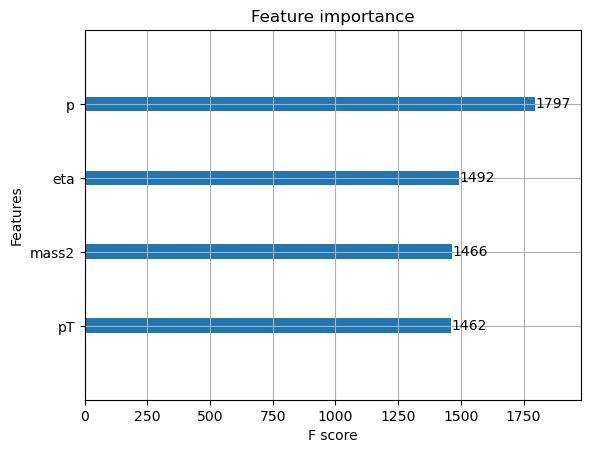

In [17]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.pdf')
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.png')

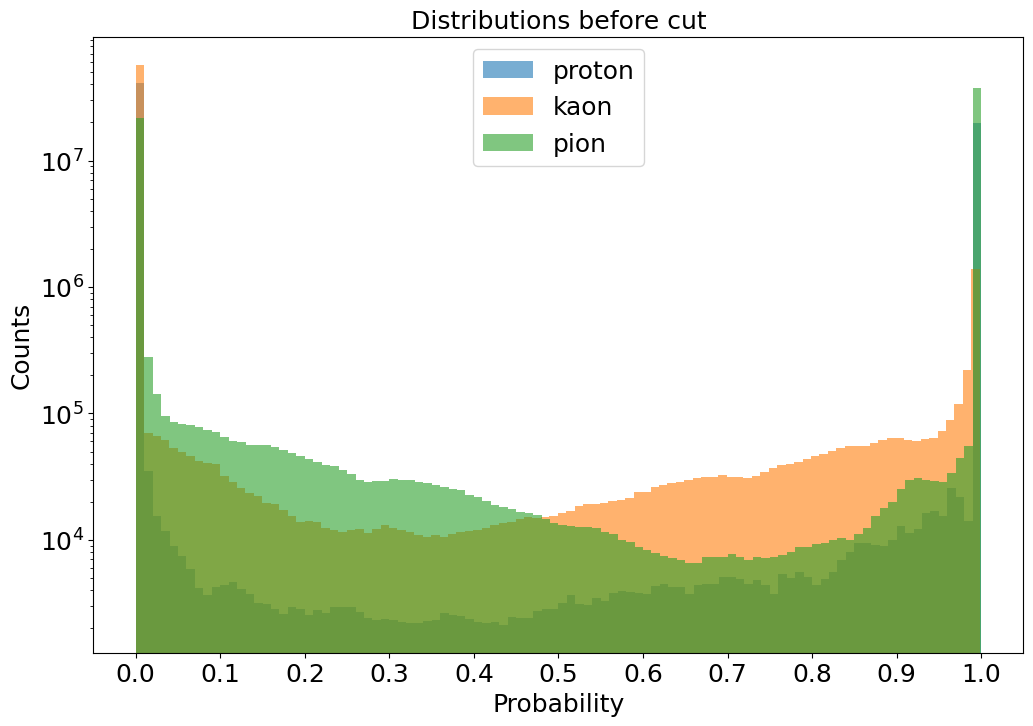

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton

plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # kaon 
plt.hist(whole_test[1], bins = 100, label='kaon', alpha = .6) # kaon 
plt.hist(whole_test[2], bins = 100, label='pion', alpha = .6) # kaon 
# plt.hist(whole_test[whole_test['pid']==1][1], bins = 100, label='kaon', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[2], bins = 100, label='pion', alpha = .6) # pion 

ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.title('Distributions before cut', fontsize=18)
plt.legend(fontsize=18)
plt.show()

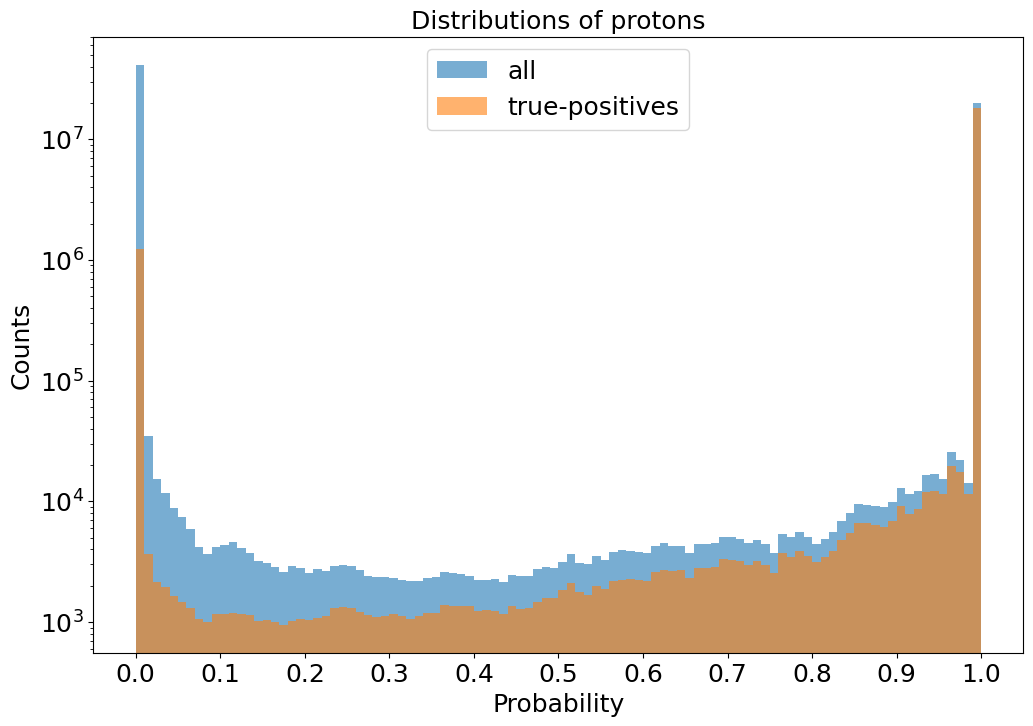

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton

plt.hist(whole_test[0], bins = 100, label='all', alpha = .6) # kaon 
plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='true-positives', alpha = .6) # kaon 

plt.title('Distributions of protons', fontsize=18)
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=18)
plt.show()

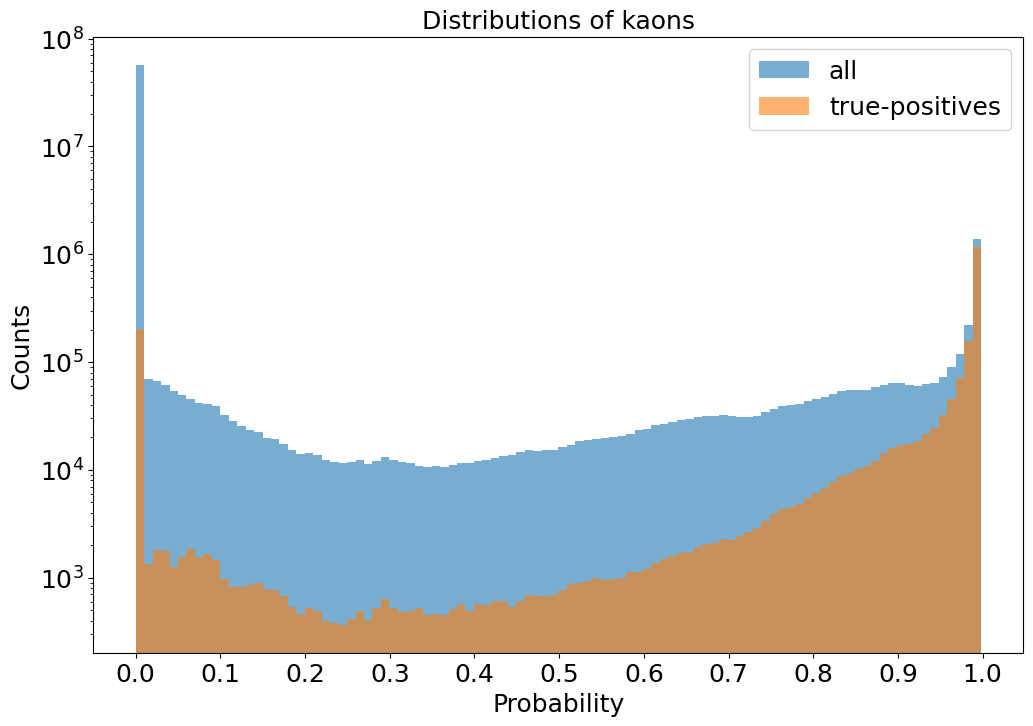

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton

plt.hist(whole_test[1], bins = 100, label='all', alpha = .6) # kaon 
plt.hist(whole_test[whole_test['pid']==1][1], bins = 100, label='true-positives', alpha = .6) # kaon 

plt.title('Distributions of kaons', fontsize=18)
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=18)
plt.show()

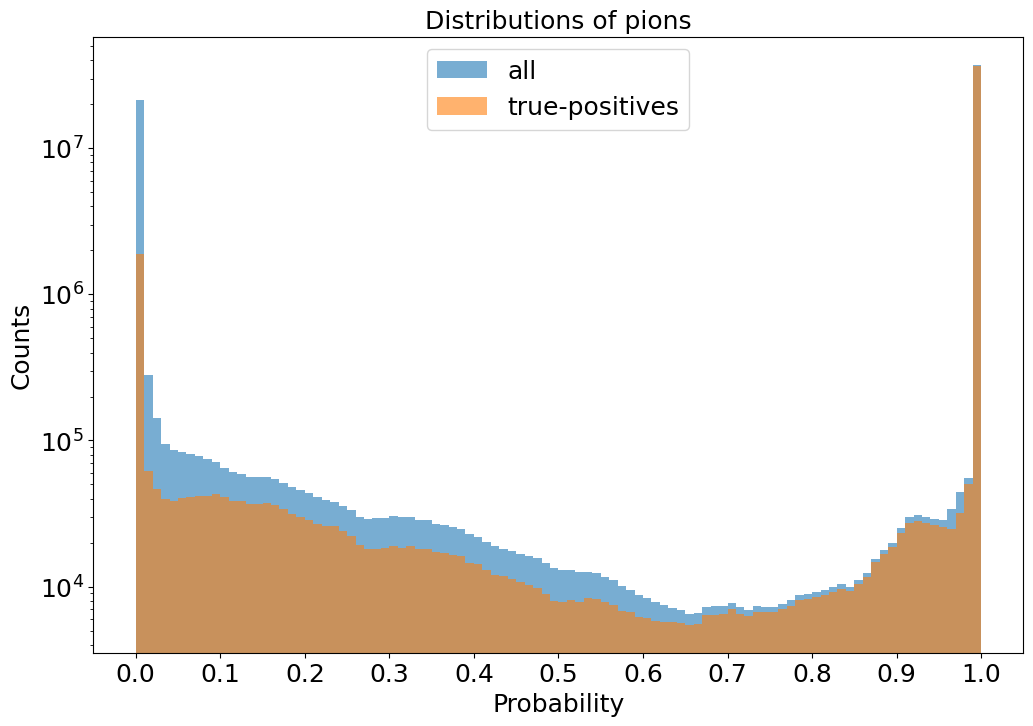

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton

plt.hist(whole_test[2], bins = 100, label='all', alpha = .6) # kaon 
plt.hist(whole_test[whole_test['pid']==2][2], bins = 100, label='true-positives', alpha = .6) # kaon 

plt.title('Distributions of pions', fontsize=18)
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=18)
plt.show()

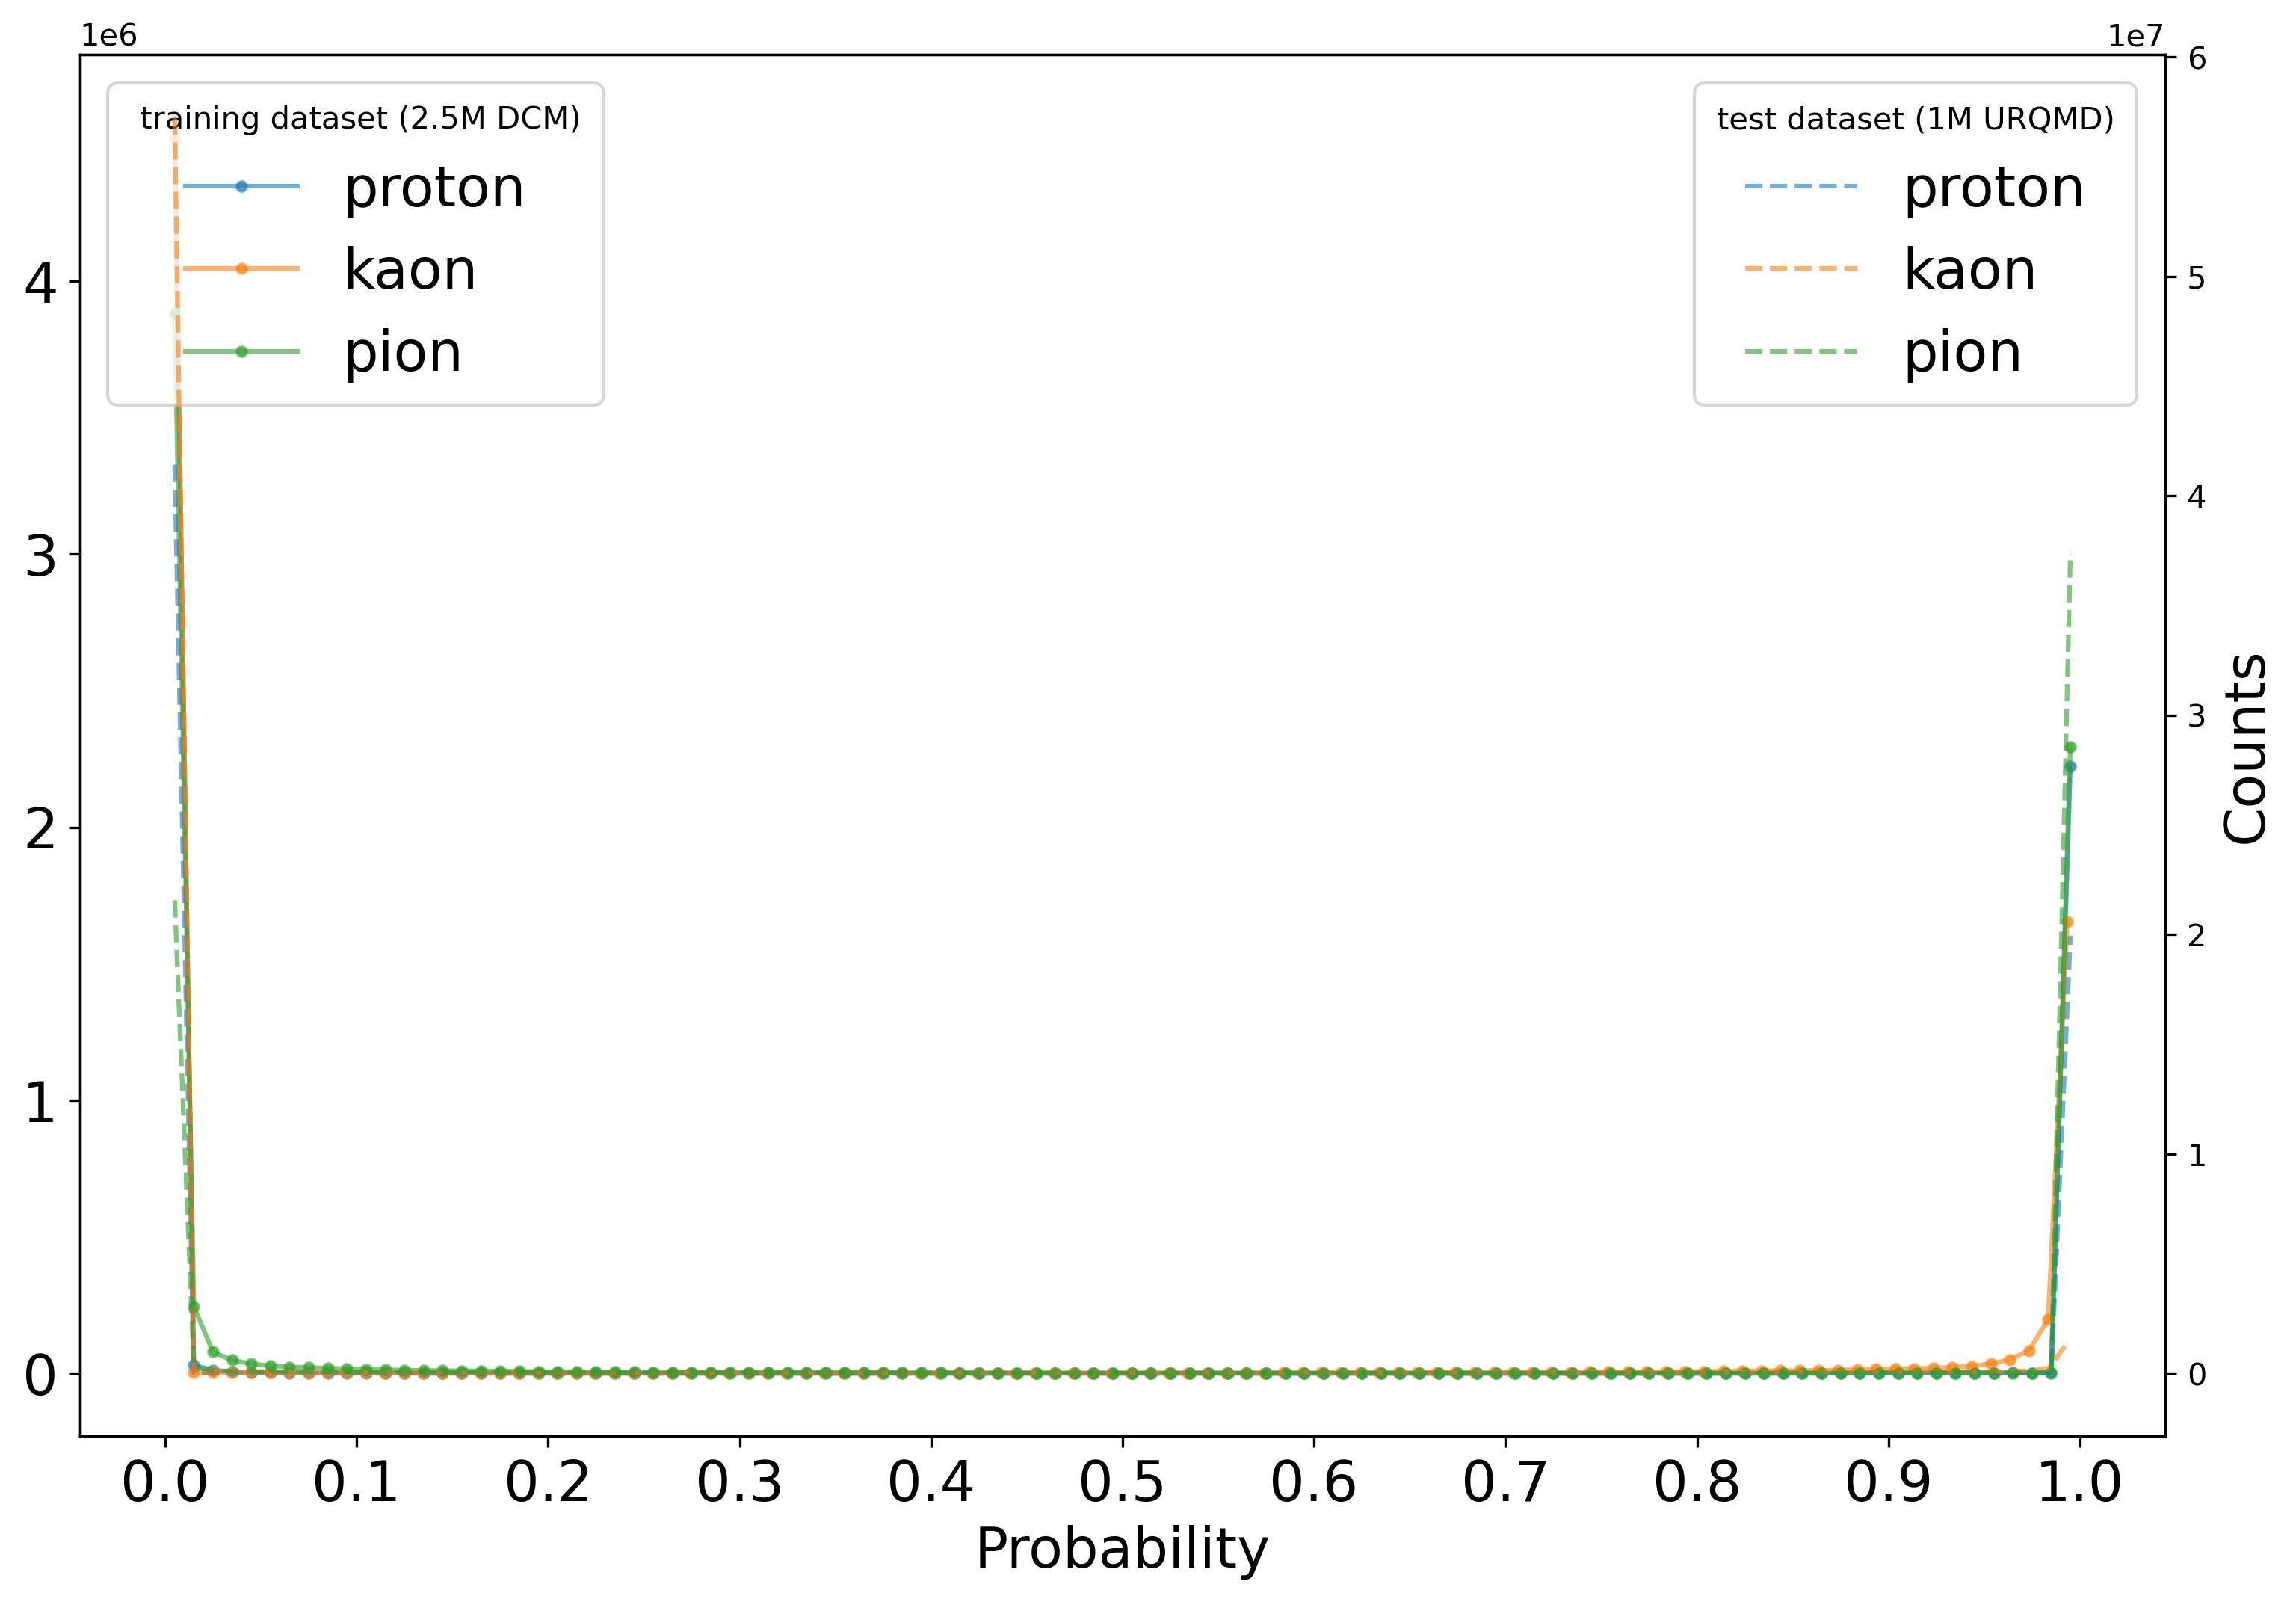

In [22]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

ax2 = ax.twinx()

def subplot(df1, df2, i, label):
    counts, bin_edges = np.histogram(df1[i],bins = 100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax.plot(bin_centers, counts, label=label, alpha = .6, marker='.')
    # ax.hist(df1[i], bins = 100, alpha = .6) 
    
    counts, bin_edges = np.histogram(df2[i],bins = 100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax2.plot(bin_centers, counts, label=label, alpha = .6, marker=',', linestyle='dashed')
    # ax.hist(df2[i], bins = 100, alpha = .6) 
    
subplot(bst_train, whole_test, 0, 'proton') 
# subplot(bst_train, whole_test, 1, 'pion')
subplot(bst_train, whole_test, 1, 'kaon')
subplot(bst_train, whole_test, 2, 'pion')
# subplot(bst_train, whole_test, 3, 'bckgr')
ax.legend(title= ' training dataset (2.5M DCM)', fontsize = 18, loc='upper left')
ax2.legend(title= 'test dataset (1M URQMD)',fontsize = 18,loc='upper right' )
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

# ax.text(0.51, 220000, r'DCM-QGSM-SMM, Au+Au @12 $A$GeV/$c$; 2.5M events', fontsize=16, color = 'black')
# ax2.text(0.52, 35000, r'URQMD, Au+Au @12 $A$GeV/$c$; 1M events', fontsize=16, color = 'black')
plt.show()

before cuts

In [23]:
#set probability cut
probaProton, probaKaon, probaPion,  = 0.0, 0.0, 0.00
whole_test = xgb_preds(whole_test, probaProton, probaKaon, probaPion)
particlesTest.index = whole_test.index
particlesTest['xgb_preds'] = whole_test['xgb_preds']

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Confusion matrix, without normalization
[[18472465   460350   822564        0]
 [   72855  1729097   166586        0]
 [ 1738713  1408458 37004737        0]
 [   11110     2506    15827        0]]


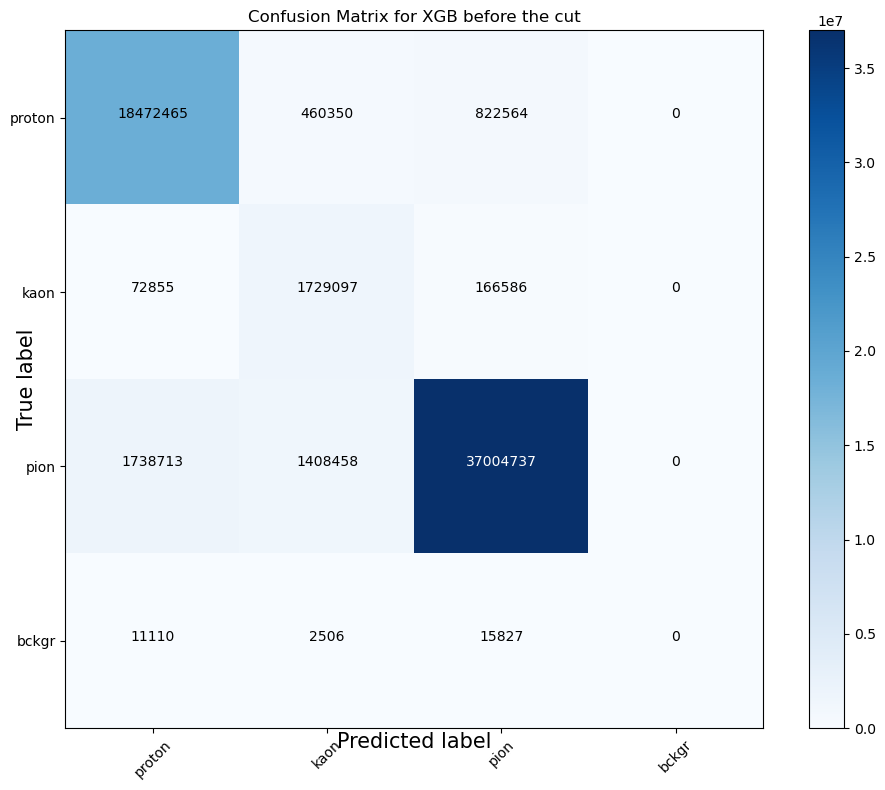

In [25]:
classes = ['proton', 'kaon', 'pion', 'bckgr']
# for particle in Pid:
#     classes.append(str(particle).replace('Pid.', ''))
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB before the cut'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=False)
# fig.savefig(directory+'img/' + title + '.pdf')
plt.show()

Normalized confusion matrix
[[0.94 0.02 0.04 0.  ]
 [0.04 0.88 0.08 0.  ]
 [0.04 0.04 0.92 0.  ]
 [0.38 0.09 0.54 0.  ]]


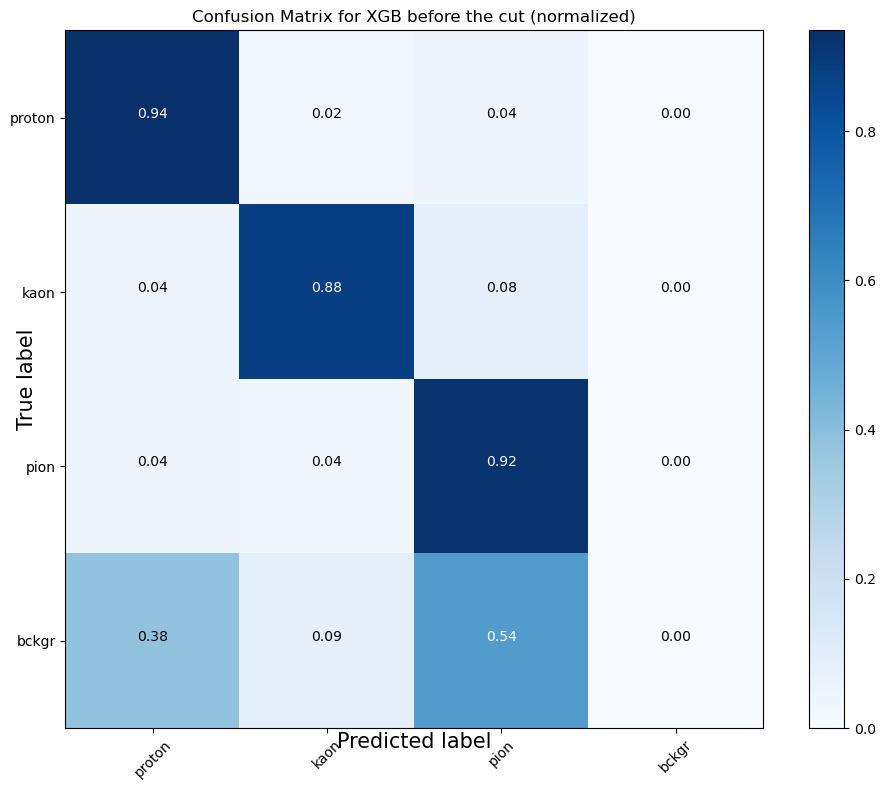

In [26]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB before the cut (normalized)'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=True)
# fig.savefig(directory+'img/' + title + '.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.png')
plt.show()

In [27]:
def plot_mass2(pid, name, range1, setLog=False):

    # fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
    #                            'height_ratios': [8,4]})
    fig, axs = plt.subplots(figsize=(15,10))

    
    xgb_mass = particlesTest[particlesTest['xgb_preds']==pid]['mass2']
    sim_mass = particlesTest[particlesTest['pid']==pid]['mass2']
    
    ns, bins, patches=axs.hist(xgb_mass ,bins = 300,  facecolor='red',alpha = 0.3, range=range1)
    ns1, bins1, patches1=axs.hist( sim_mass ,bins = 300,facecolor='blue',alpha = 0.3, range=range1)
    #plt.xlabel("Mass in GeV", fontsize = 15)
    axs.set_ylabel("counts", fontsize = 15)
    #axs[0].grid()
    axs.legend(('XGBoost selected ' + name,'all simulated ' + name), fontsize = 15, loc='upper right')

    #plt.rcParams["legend.loc"] = 'upper right'
    title = "The " + name +  " Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables"
    axs.set_title(title, fontsize = 15)
    axs.grid()
    axs.tick_params(axis='both', which='major', labelsize=15)
    #fig.savefig("whole_sample_invmass_with_ML.png")


    # hist1, bin_edges1 = np.histogram(xgb_mass, bins=200, range=range1)
#     hist2, bin_edges2 = np.histogram(sim_mass, bins=200, range=range1)

#     #ratio checked with division by 0
#     ratioBlue = [] #ratio smaller than 1
#     ratioRed = [] # ratio bigger than 1
#     for i in range(len(ns1)):
#         if (ns1[i] != 0):
#             ratio = ns[i] / ns1[i]
#             if (ratio < 1):
#                 ratioBlue.append(ratio)
#                 ratioRed.append(0)
#             else:
#                 ratioBlue.append(0)
#                 ratioRed.append(ratio)
#         else:
#             ratioBlue.append(0)
#             ratioRed.append(0)
#     #col = []
#     # for val in ratio:
#     #     if val < 1:
#     #         col.append('blue')
#     #     else:
#     #         col.append('red')        
#     axs[1].bar(bins[:-1],     
#             ratioBlue, 
#             width=0.001,
#             color = 'blue',
#             label='ratio < 1')
#     axs[1].bar(bins[:-1],     
#             ratioRed, 
#             width=0.001,
#             color = 'red',
#             label='ratio >= 1')
#     axs[1].legend( loc='upper right')
#     plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
#     axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
#     axs[1].grid()
#     #axs[1].set_ylim([0.,2.5])
#     axs[1].tick_params(axis='both', which='major', labelsize=15)
    if setLog:
        axs.set_yscale('log')

    plt.show()
    fig.tight_layout()
    # fig.savefig(directory+'img/' + title + '.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison.png')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison.pdf')

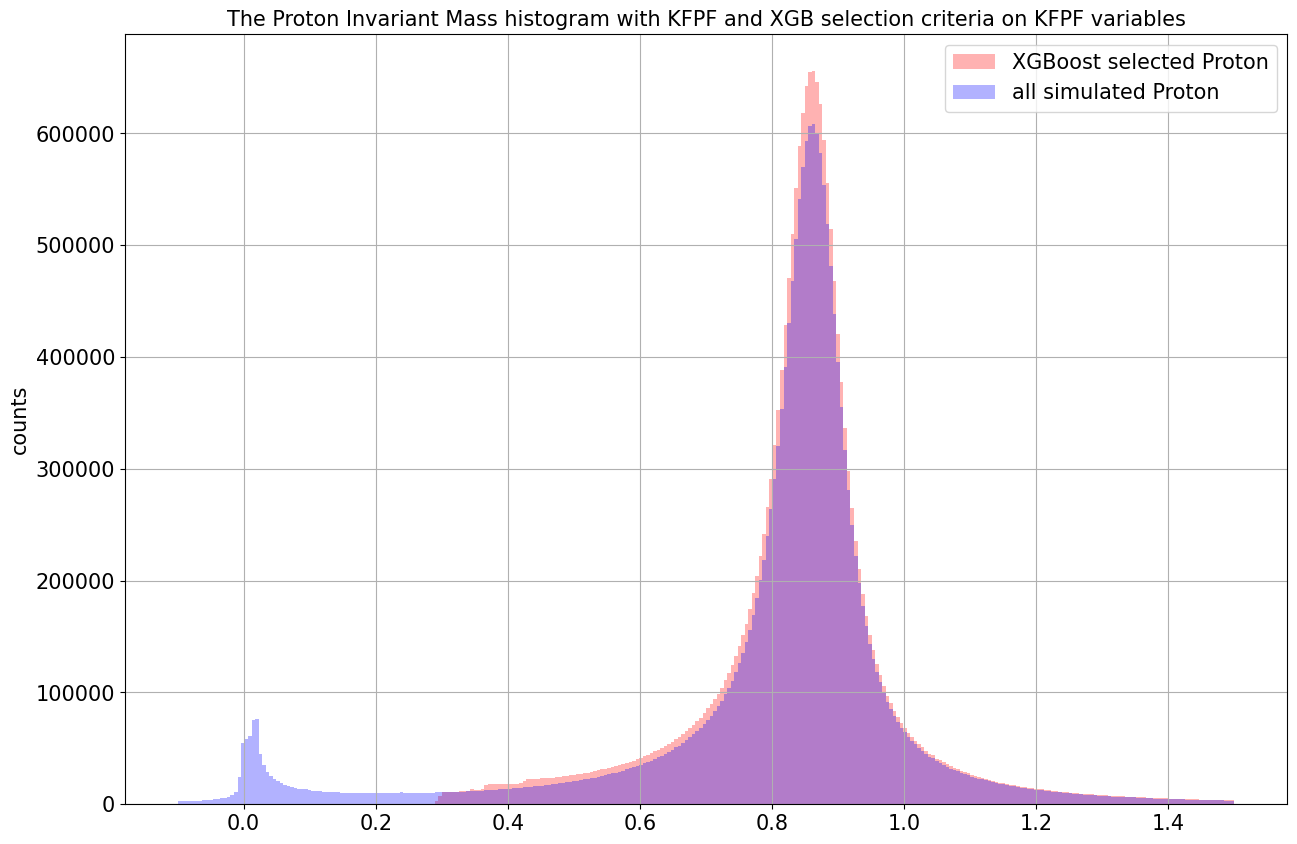

In [28]:
plot_mass2(0, 'Proton', (-.1, 1.5))

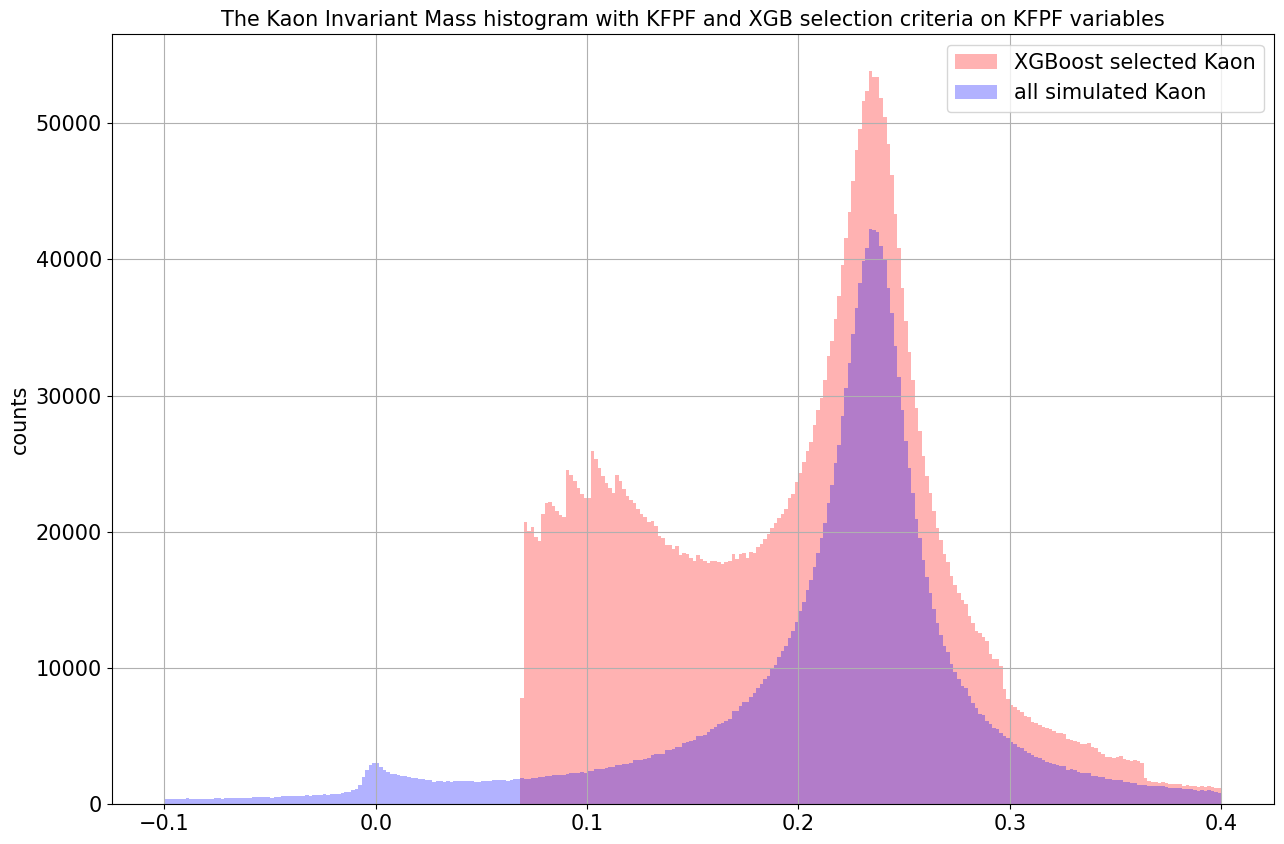

In [29]:
plot_mass2(1, 'Kaon', (-.1, .4))

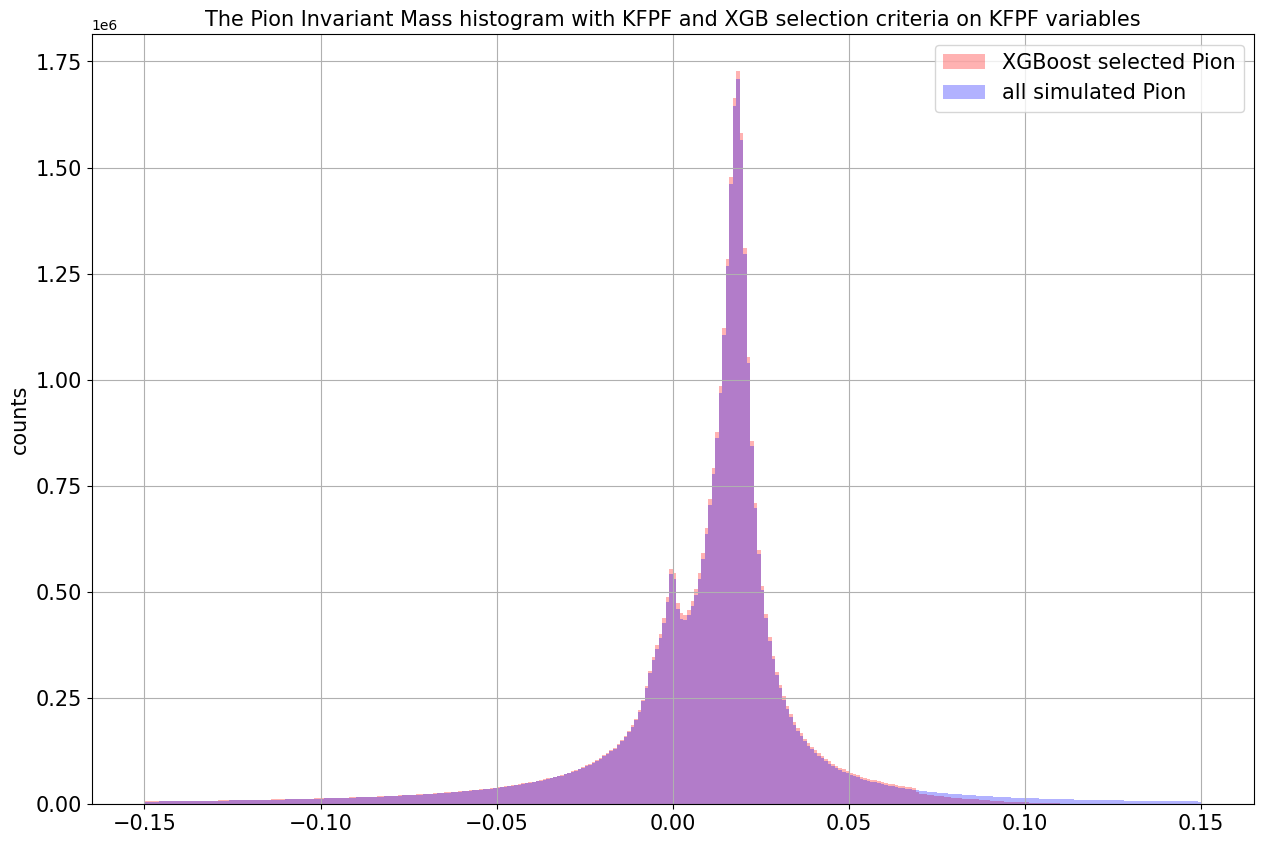

In [30]:
plot_mass2(2, 'Pion', (-.15, .15))

In [31]:
import matplotlib as mpl
def xgb_tof(pid):

    qp = particlesTest[particlesTest['xgb_preds']==pid]['q']*particlesTest[particlesTest['xgb_preds']==pid]['p']
    var_xaxis = qp
    mass2 = particlesTest[particlesTest['xgb_preds']==pid]['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for XGB-selected particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')

In [32]:
import matplotlib as mpl
def sim_tof(pid):

    qp = particlesTest[particlesTest['pid']==pid]['q']*particlesTest[particlesTest['pid']==pid]['p']
    var_xaxis = qp
    mass2 = particlesTest[particlesTest['pid']==pid]['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c^2)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')

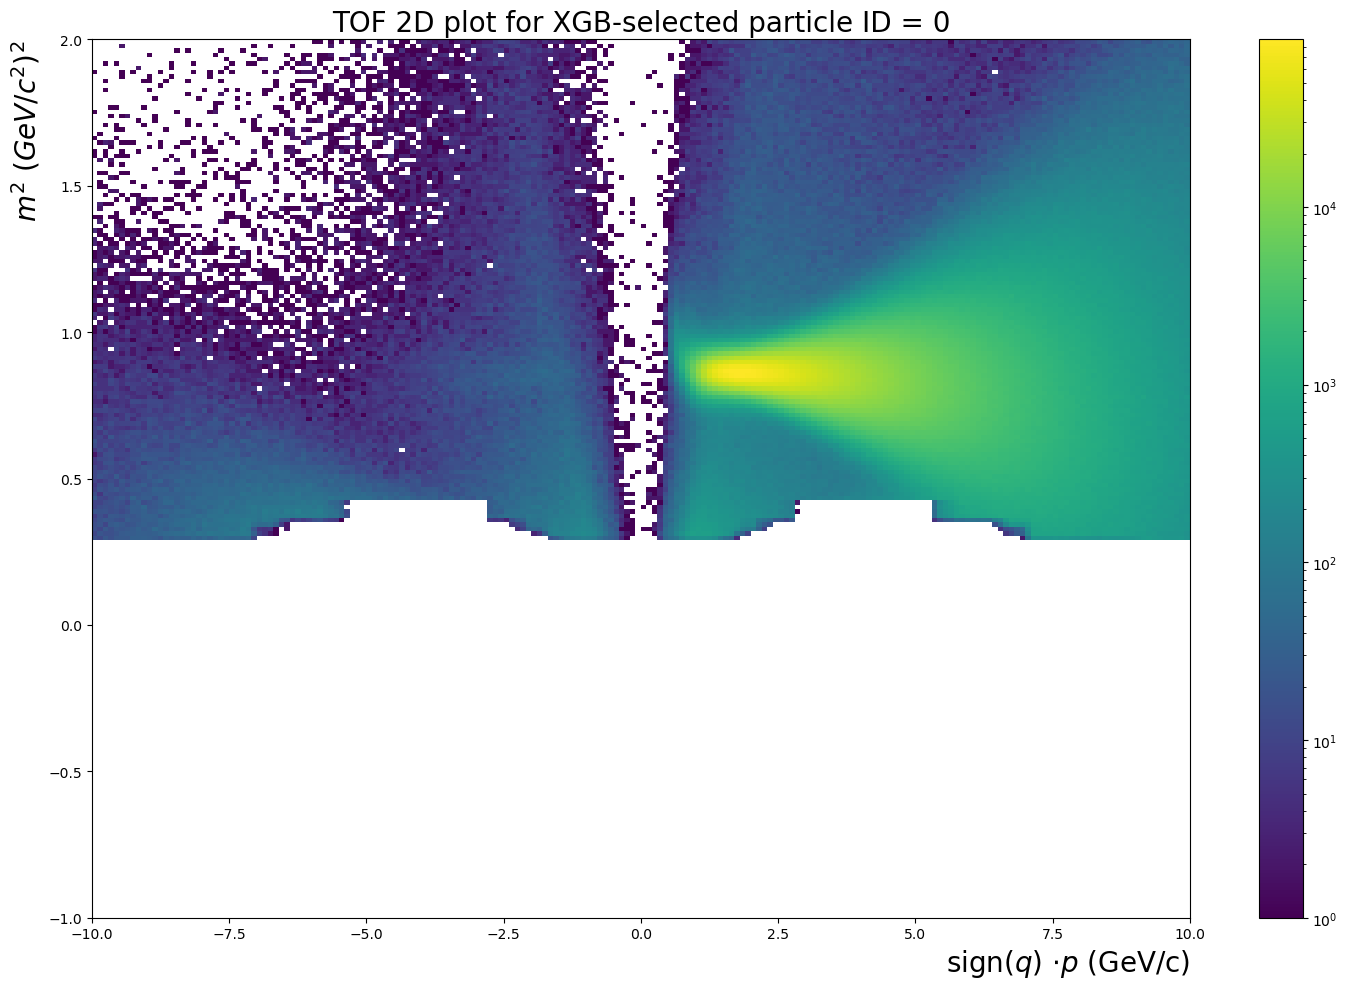

In [33]:
xgb_tof(0)

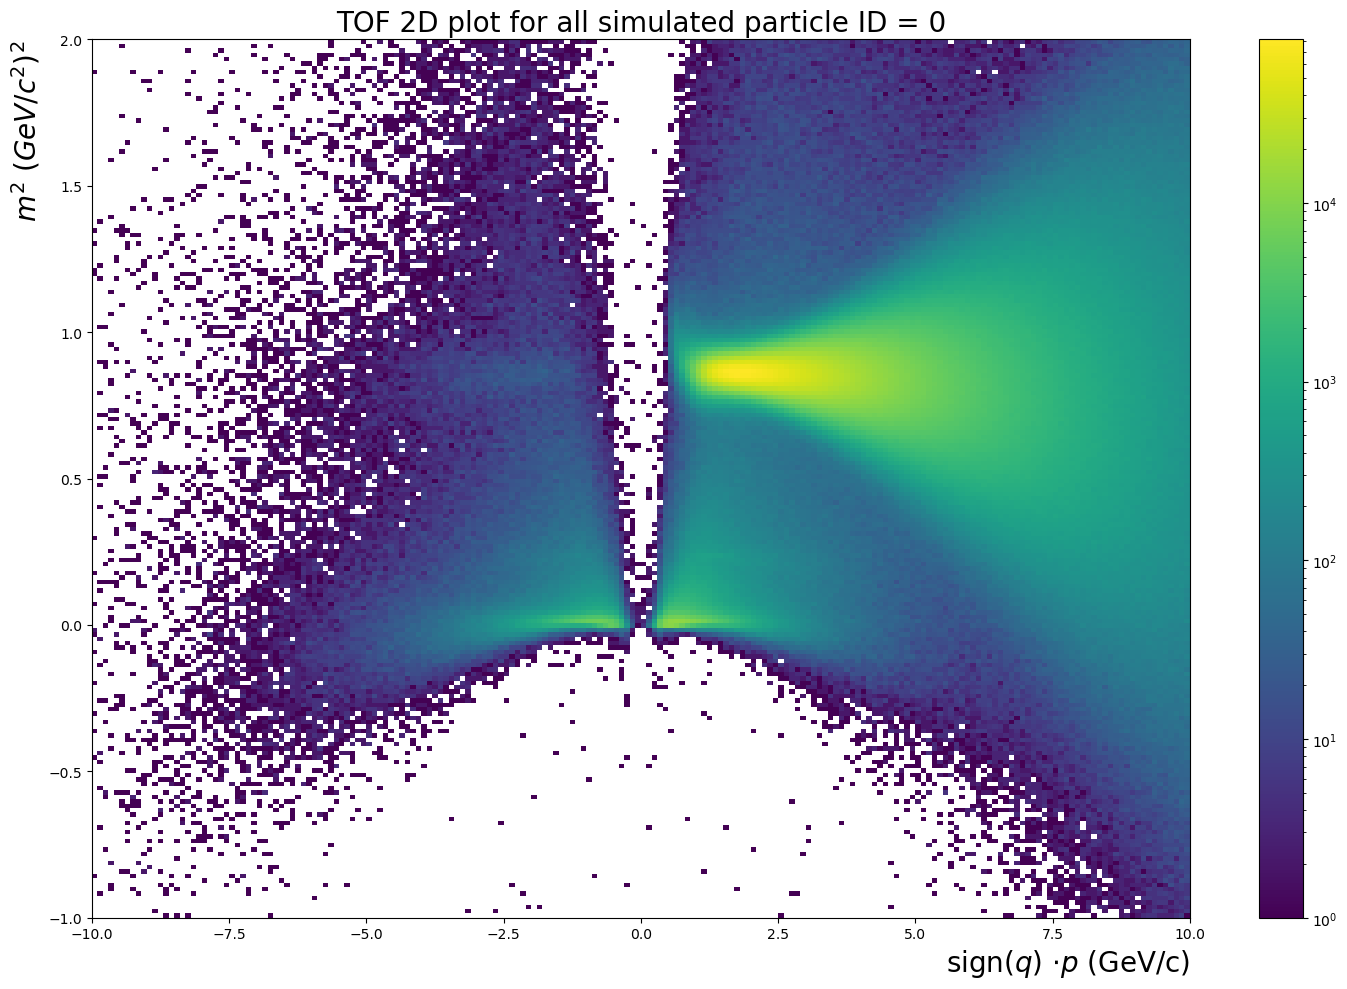

In [34]:
sim_tof(0)

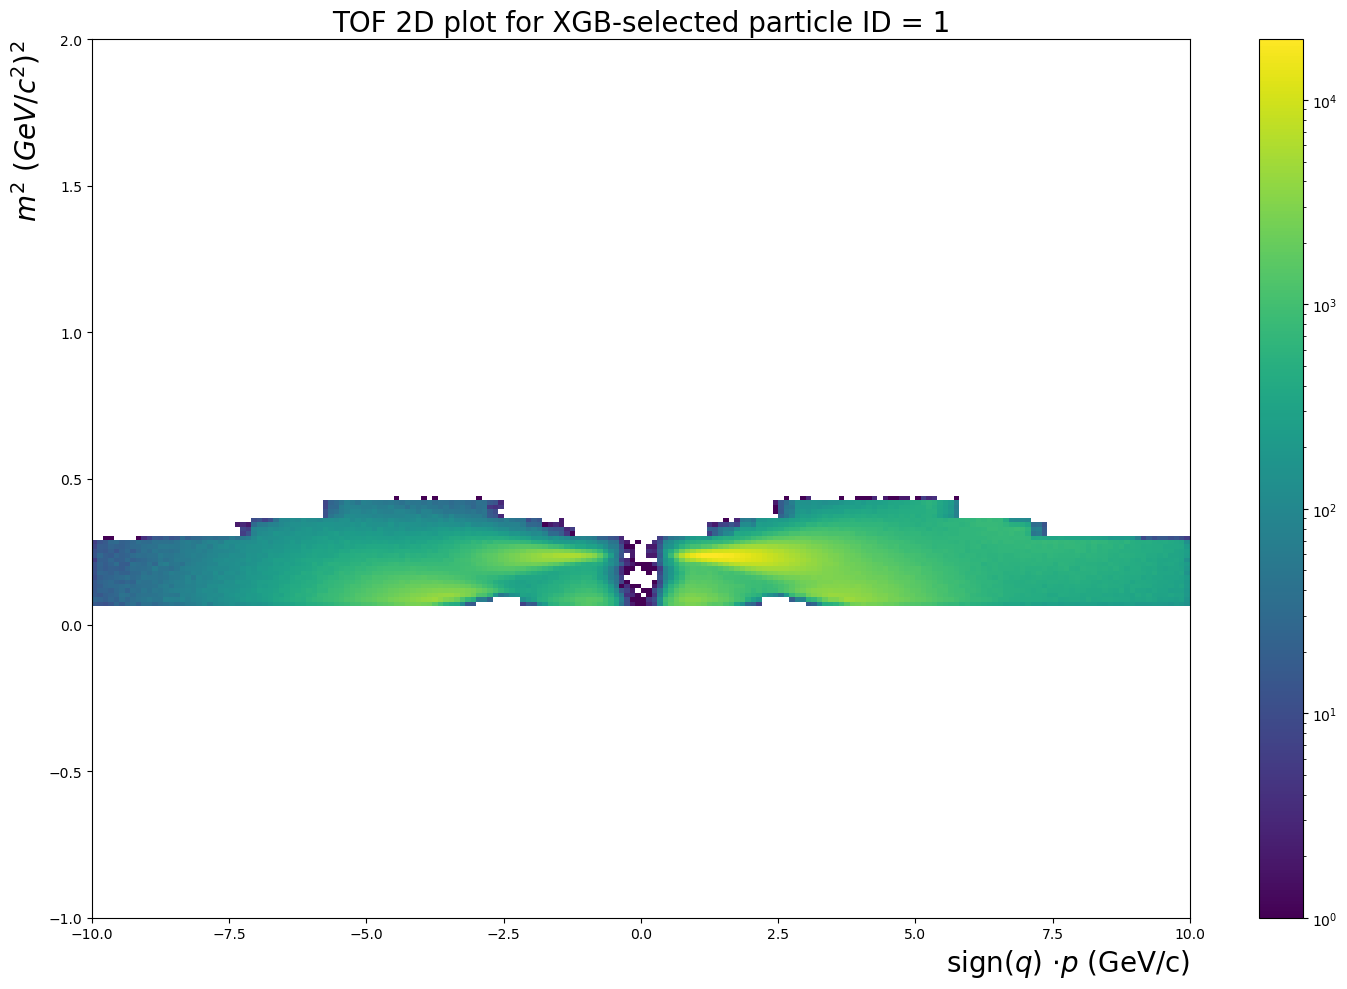

In [35]:
xgb_tof(1)

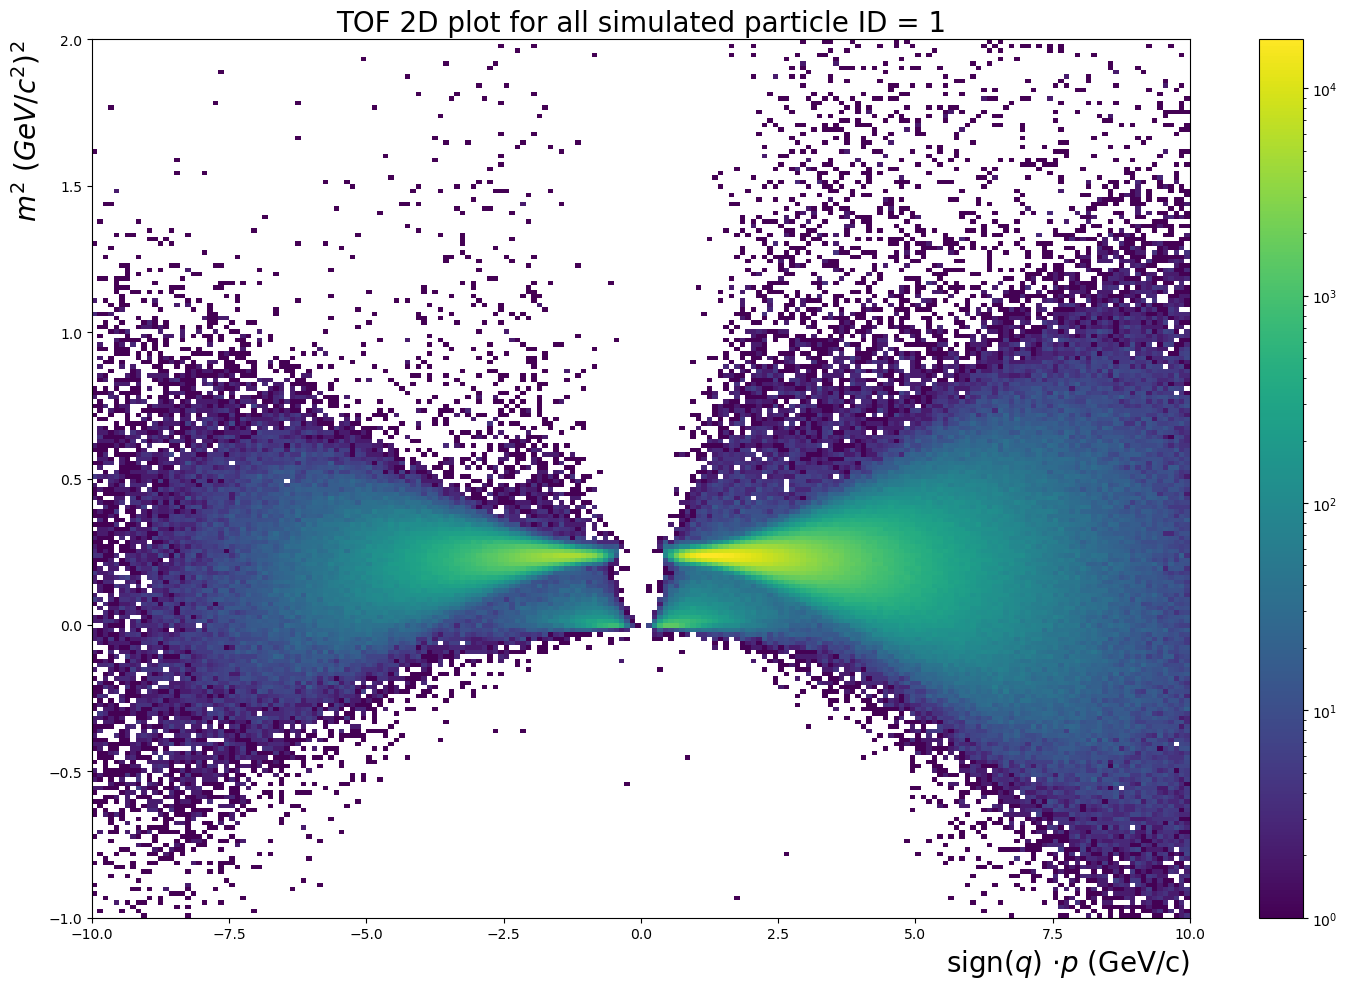

In [36]:
sim_tof(1)

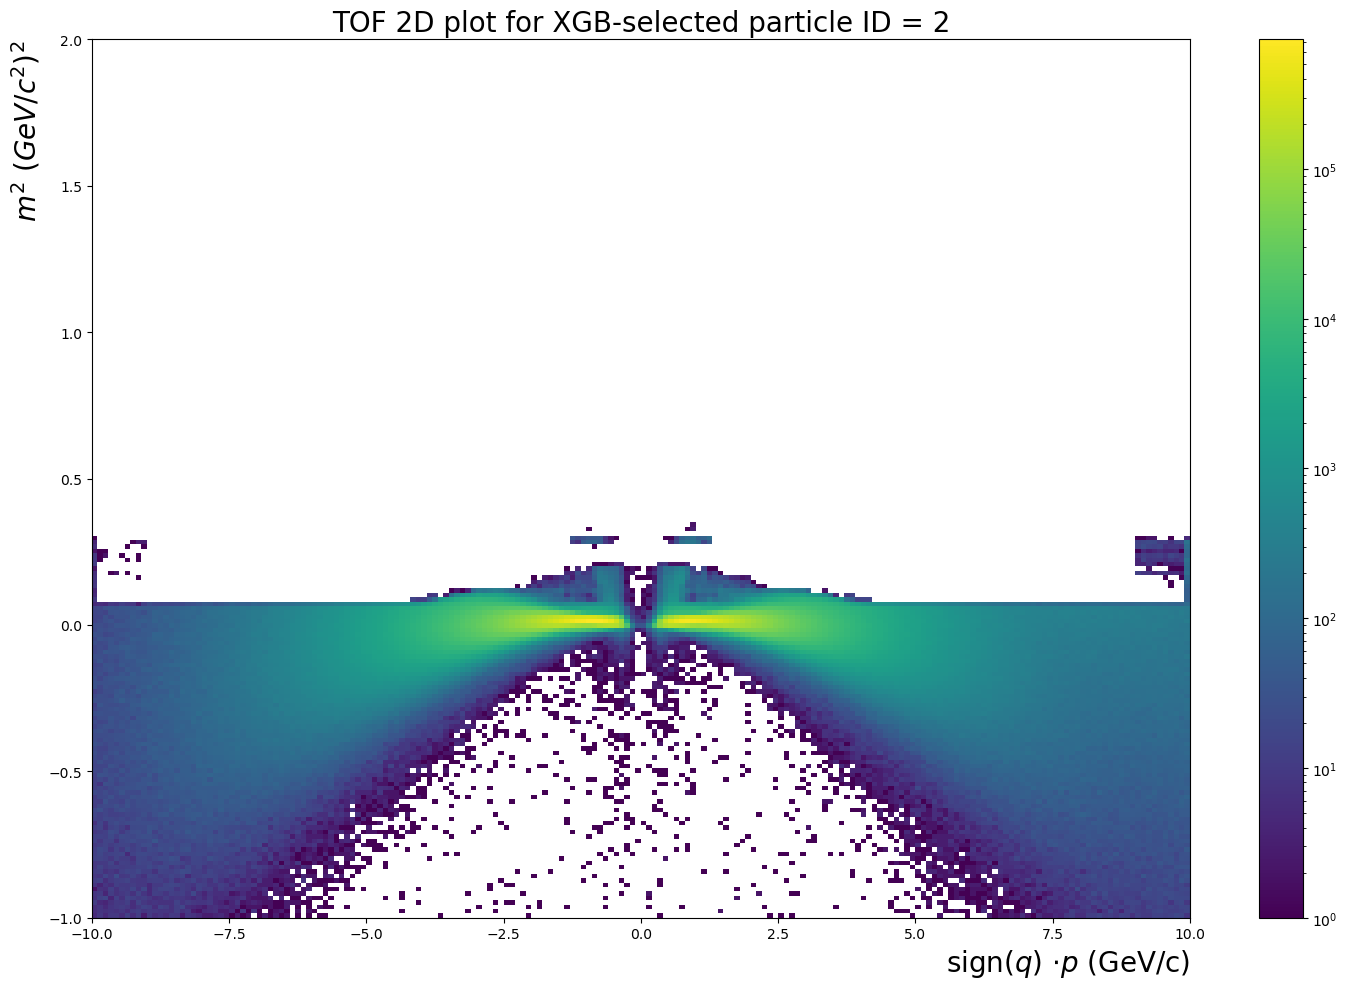

In [37]:
xgb_tof(2)

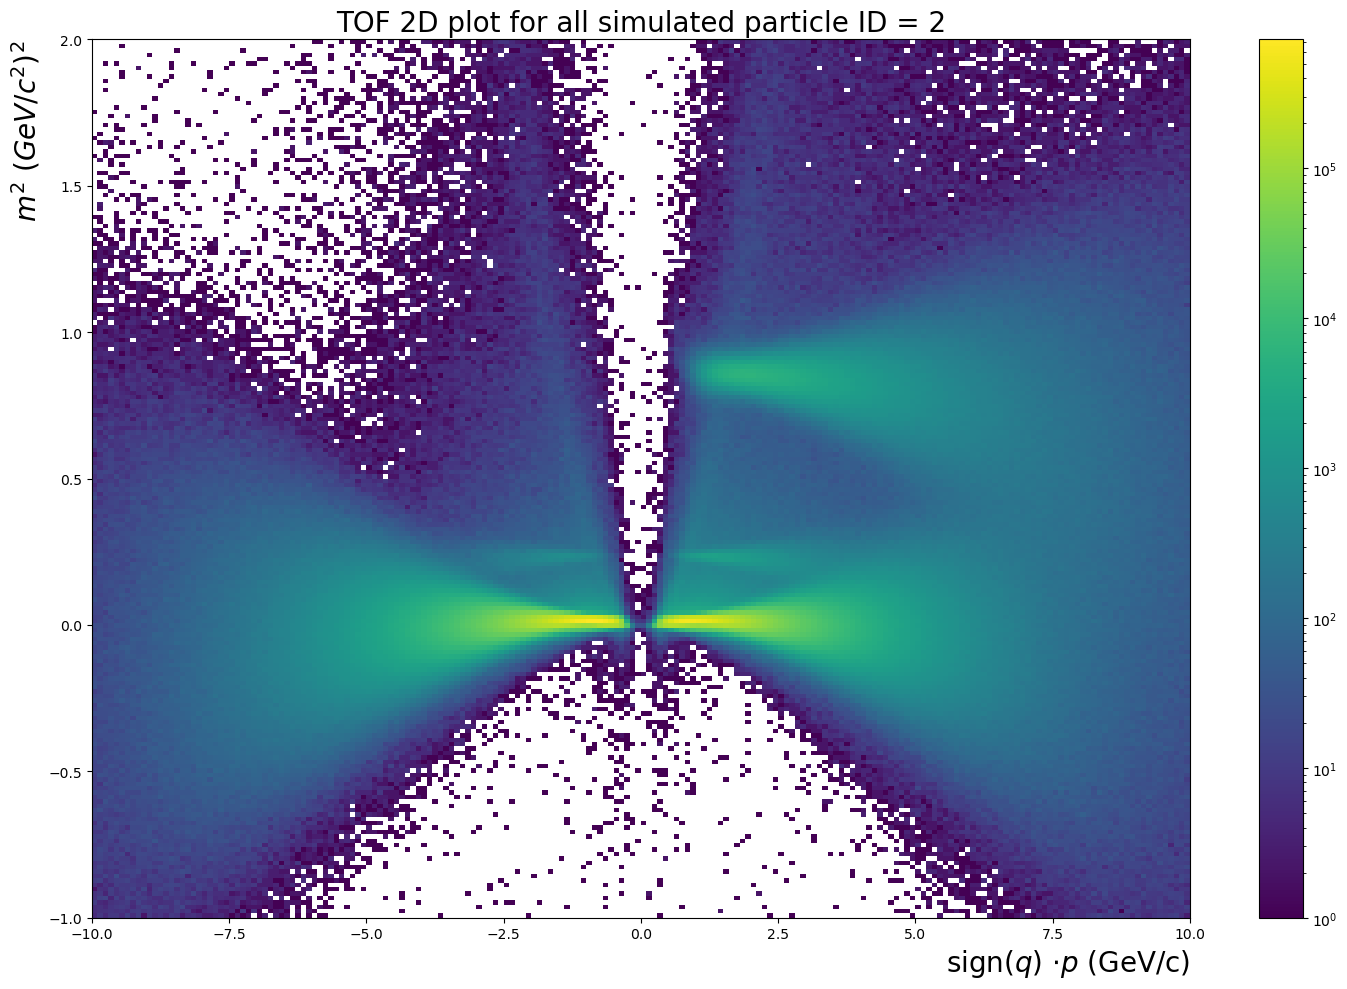

In [38]:
sim_tof(2)

In [39]:
#set probability cut
probaProton, probaKaon, probaPion,  = .88, .96, .82
whole_test = xgb_preds(whole_test, probaProton, probaKaon, probaPion)
particlesTest.index = whole_test.index
particlesTest['xgb_preds'] = whole_test['xgb_preds']

In [40]:
particlesTest.iloc[0:10,:]

,eta,mass,mass2,p,pT,phi,px,py,pz,rapidity,pid,q,xgb_preds
0,2.795109,0.139570,0.044752,3.360802,0.409217,-1.931746,-0.144520,-0.382848,3.335796,2.740521,2,-1.0,2
1,2.862100,0.493677,0.248146,2.920601,0.332732,-1.740885,-0.056321,-0.327931,2.901586,2.287393,1,1.0,1
2,2.025051,0.938272,0.904669,2.650691,0.687733,-2.986821,-0.679512,-0.106017,2.559919,1.529873,0,1.0,0
3,1.962085,0.938272,0.842410,3.123042,0.860970,-0.086505,0.857751,-0.074385,3.002019,1.592940,0,1.0,0
4,2.162448,0.139570,-0.004009,2.821904,0.640801,0.066599,0.639381,0.042645,2.748184,2.139893,2,-1.0,2
5,3.121445,0.938272,1.108287,6.939540,0.610784,1.233429,0.202172,0.576353,6.912608,2.520050,0,1.0,0
6,2.217318,0.938272,0.834824,2.472587,0.532222,2.700255,-0.481225,0.227338,2.414628,1.545454,0,1.0,0
7,2.156020,0.938272,0.882386,5.610508,1.282038,0.950416,0.745306,1.043139,5.462068,1.948566,0,1.0,0
8,2.211525,0.139570,0.015155,1.712385,0.370680,1.318592,0.092499,0.358953,1.671783,2.146911,2,1.0,2
9,1.950903,0.139570,0.015053,1.949115,0.543142,2.232159,-0.333594,0.428624,1.871910,1.920236,2,-1.0,2


Confusion matrix, without normalization
[[18346347    77171   768285   563576]
 [   59573  1424711   160069   324185]
 [ 1683949   297049 36781998  1388912]
 [   10882      960    15542     2059]]


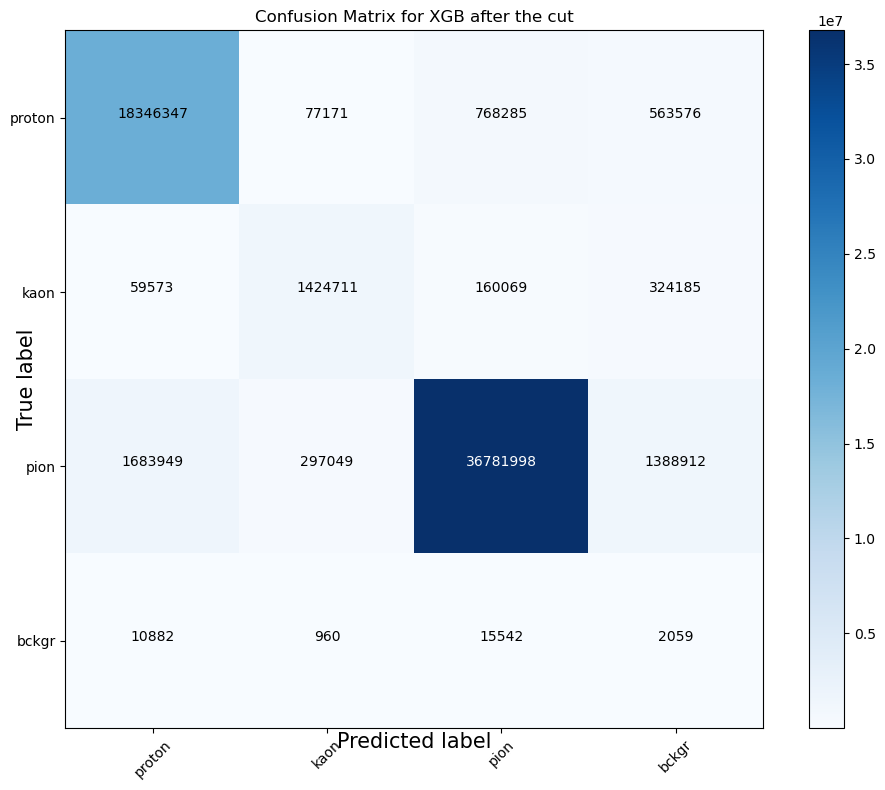

In [41]:
classes = ['proton', 'kaon', 'pion', 'bckgr']
# for particle in Pid:
#     classes.append(str(particle).replace('Pid.', ''))
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB after the cut'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=False)
fig.savefig(directory+'img/' + title + '.pdf')

plt.show()

Normalized confusion matrix
[[0.93 0.   0.04 0.03]
 [0.03 0.72 0.08 0.16]
 [0.04 0.01 0.92 0.03]
 [0.37 0.03 0.53 0.07]]


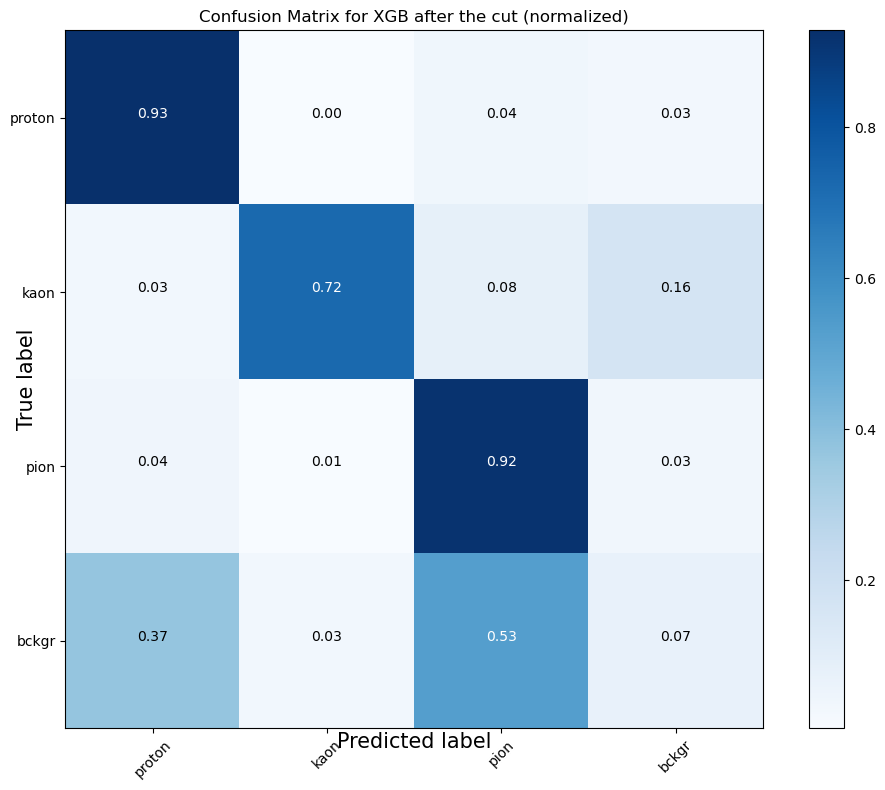

In [42]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)

title = 'Confusion Matrix for XGB after the cut (normalized)'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=True)
fig.savefig(directory+'img/' + title + '.pdf')

plt.show()

In [43]:
def confusion_stats(df, cm, pid):
    all_signals = len(df.loc[df['pid'] == pid])
    true_signal = cm[pid][pid]
    false_signal = 0
    for i in range(len(cnf_matrix)):
        if i != pid:
            false_signal += cm[pid][i] + cm[i][pid]
    reconstructed_signals = true_signal + false_signal
    false_to_true_signals = false_signal / true_signal
    efficiency = reconstructed_signals / all_signals * 100 #efficency in % for all
    efficiency_true = true_signal / all_signals * 100 #efficency in % for all
    print("For particle ID = " + str(pid) + ": ")
    print("Efficiency: " + str(round(efficiency, 2)) + "%")
    print("Efficiency of true signal candidates reconstruction: " + str(round(efficiency_true, 2)) + "%")
    print("False tu true positives ratio: " + str(round(false_to_true_signals, 2)))
    
confusion_stats(whole_test, cnf_matrix, 0)
confusion_stats(whole_test, cnf_matrix, 1)
confusion_stats(whole_test, cnf_matrix, 2)

For particle ID = 0: 
Efficiency: 108.88%
Efficiency of true signal candidates reconstruction: 92.87%
False tu true positives ratio: 0.17
For particle ID = 1: 
Efficiency: 119.06%
Efficiency of true signal candidates reconstruction: 72.37%
False tu true positives ratio: 0.65
For particle ID = 2: 
Efficiency: 102.35%
Efficiency of true signal candidates reconstruction: 91.61%
False tu true positives ratio: 0.12


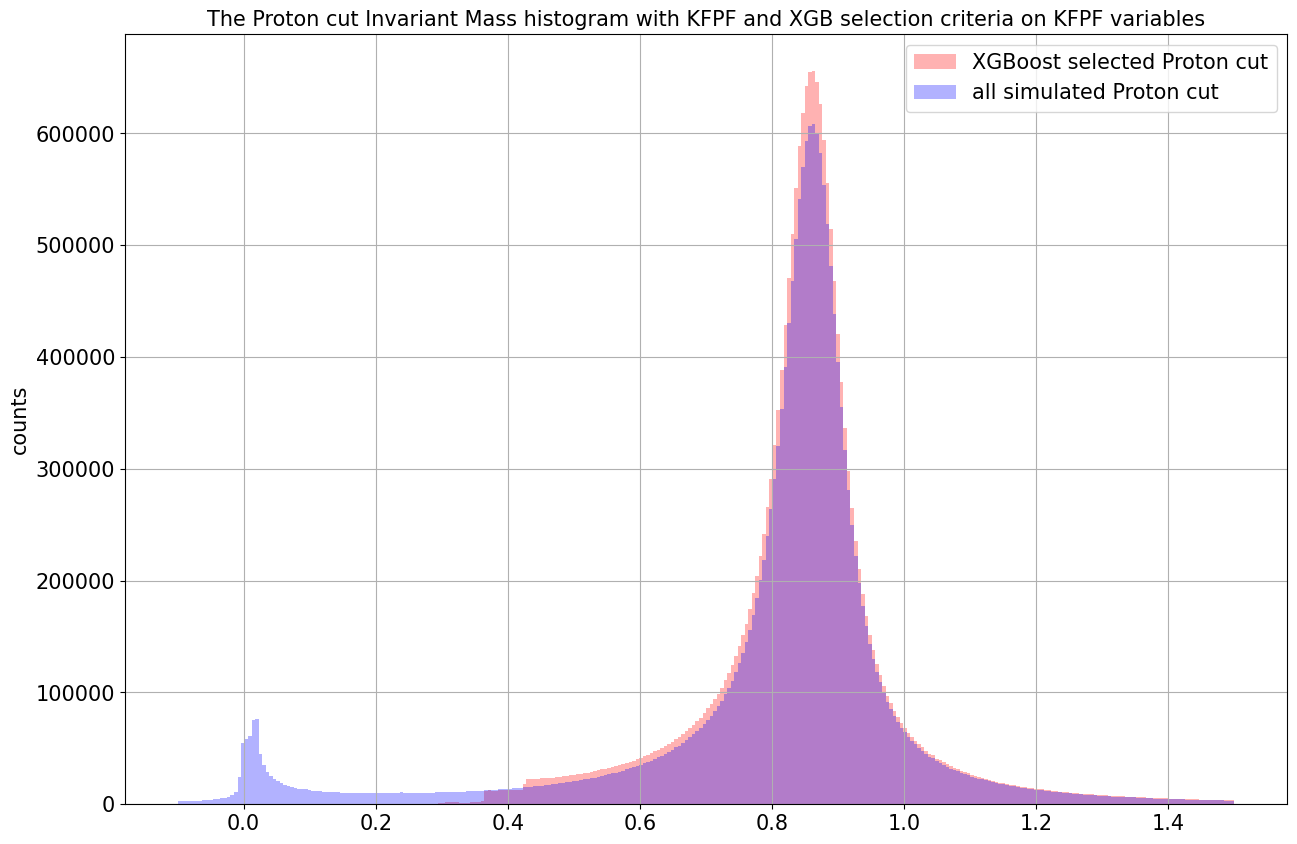

In [44]:
plot_mass2(0, 'Proton cut', (-.1, 1.5))

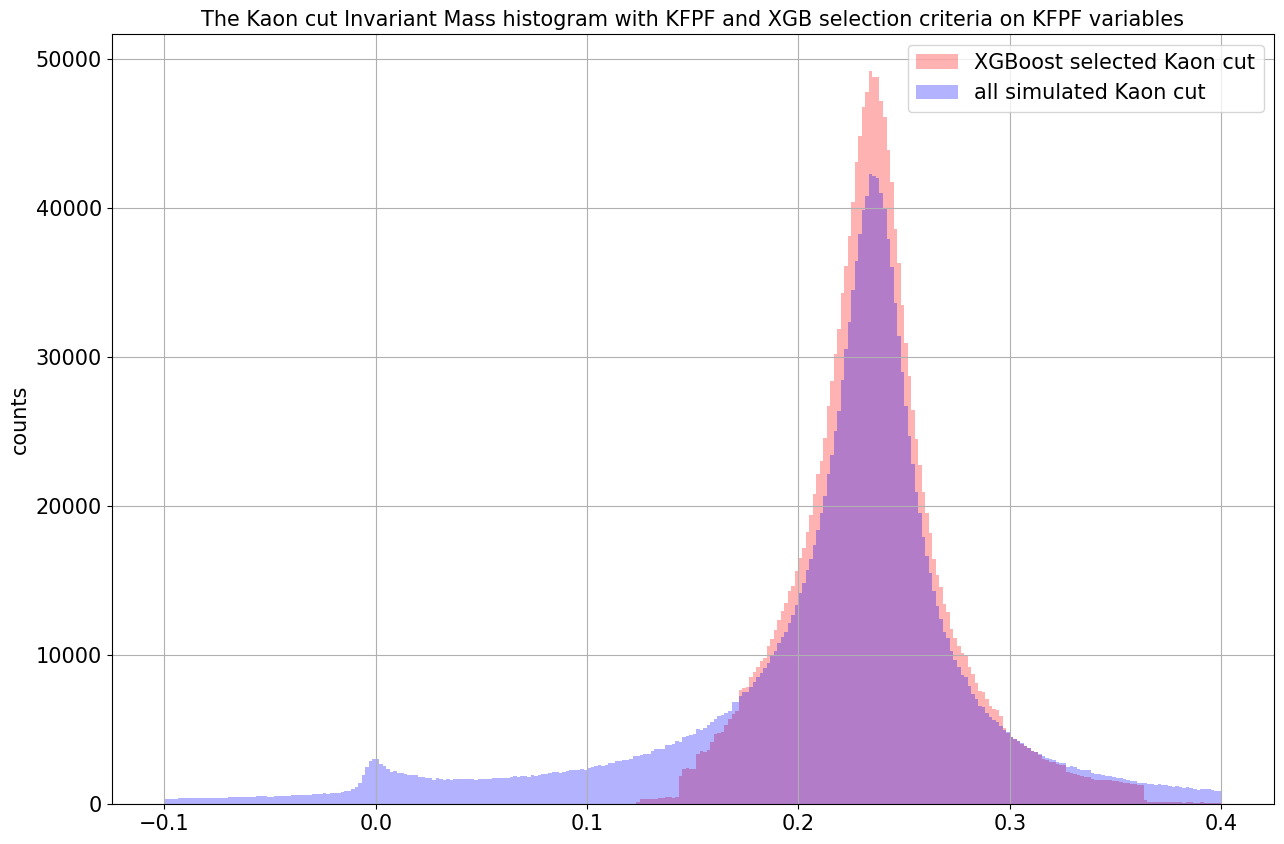

In [45]:
plot_mass2(1, 'Kaon cut', (-.1, .4))

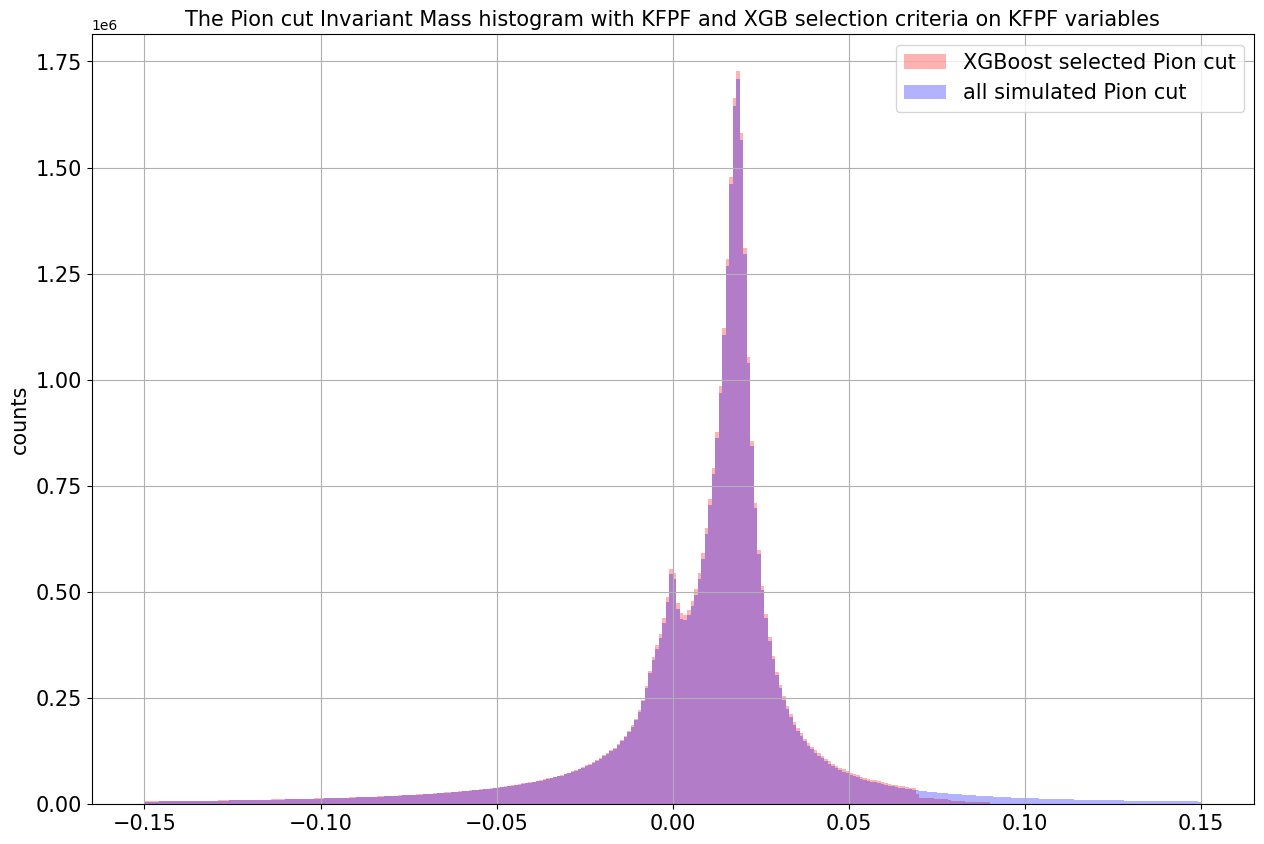

In [46]:
plot_mass2(2, 'Pion cut', (-.15, .15))

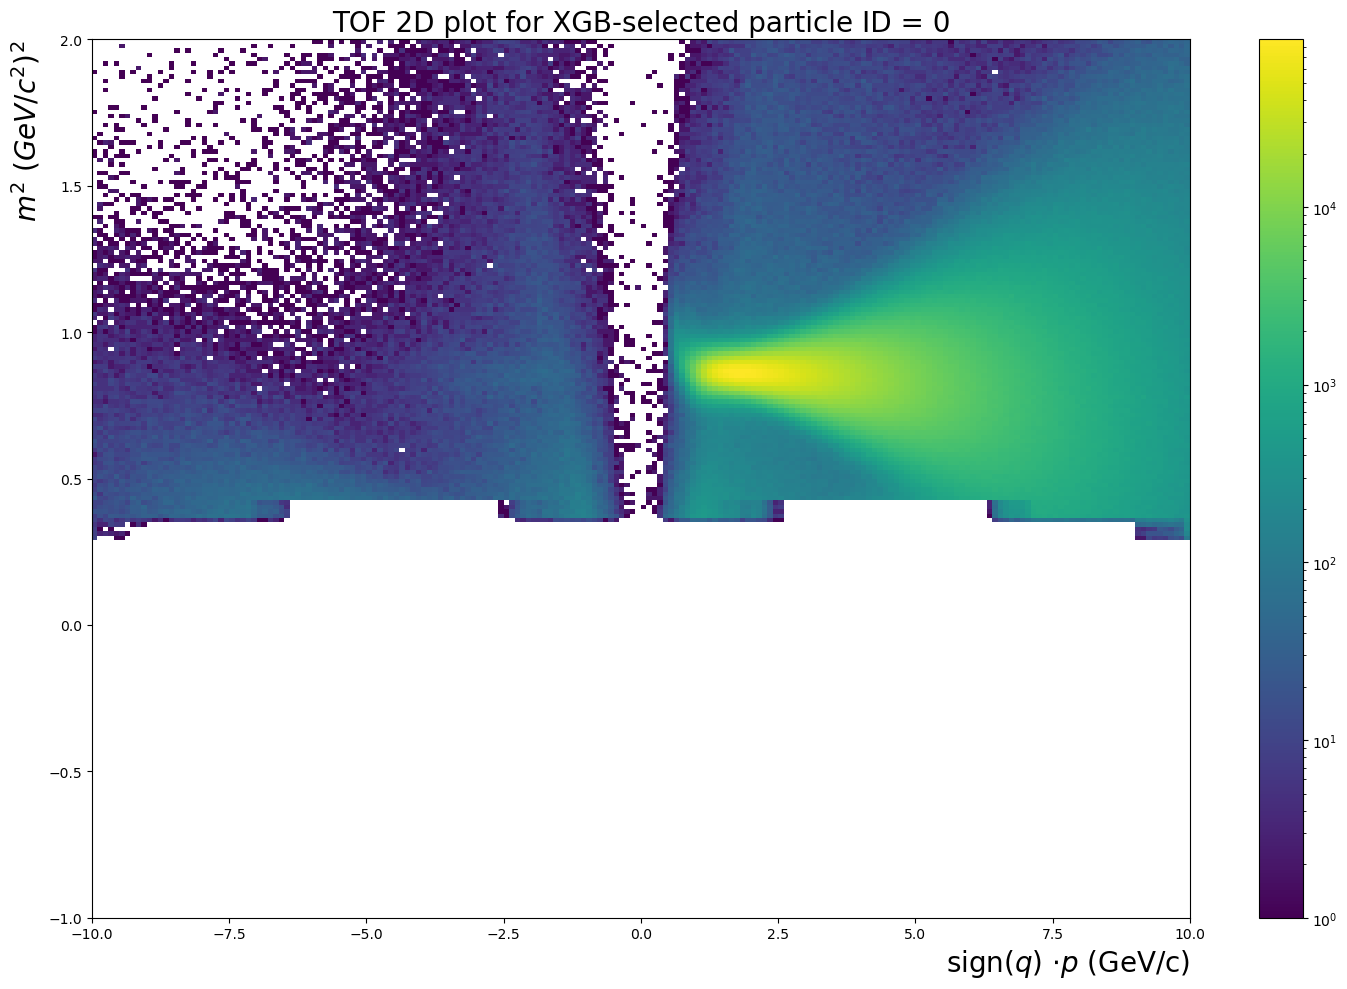

In [47]:
xgb_tof(0)

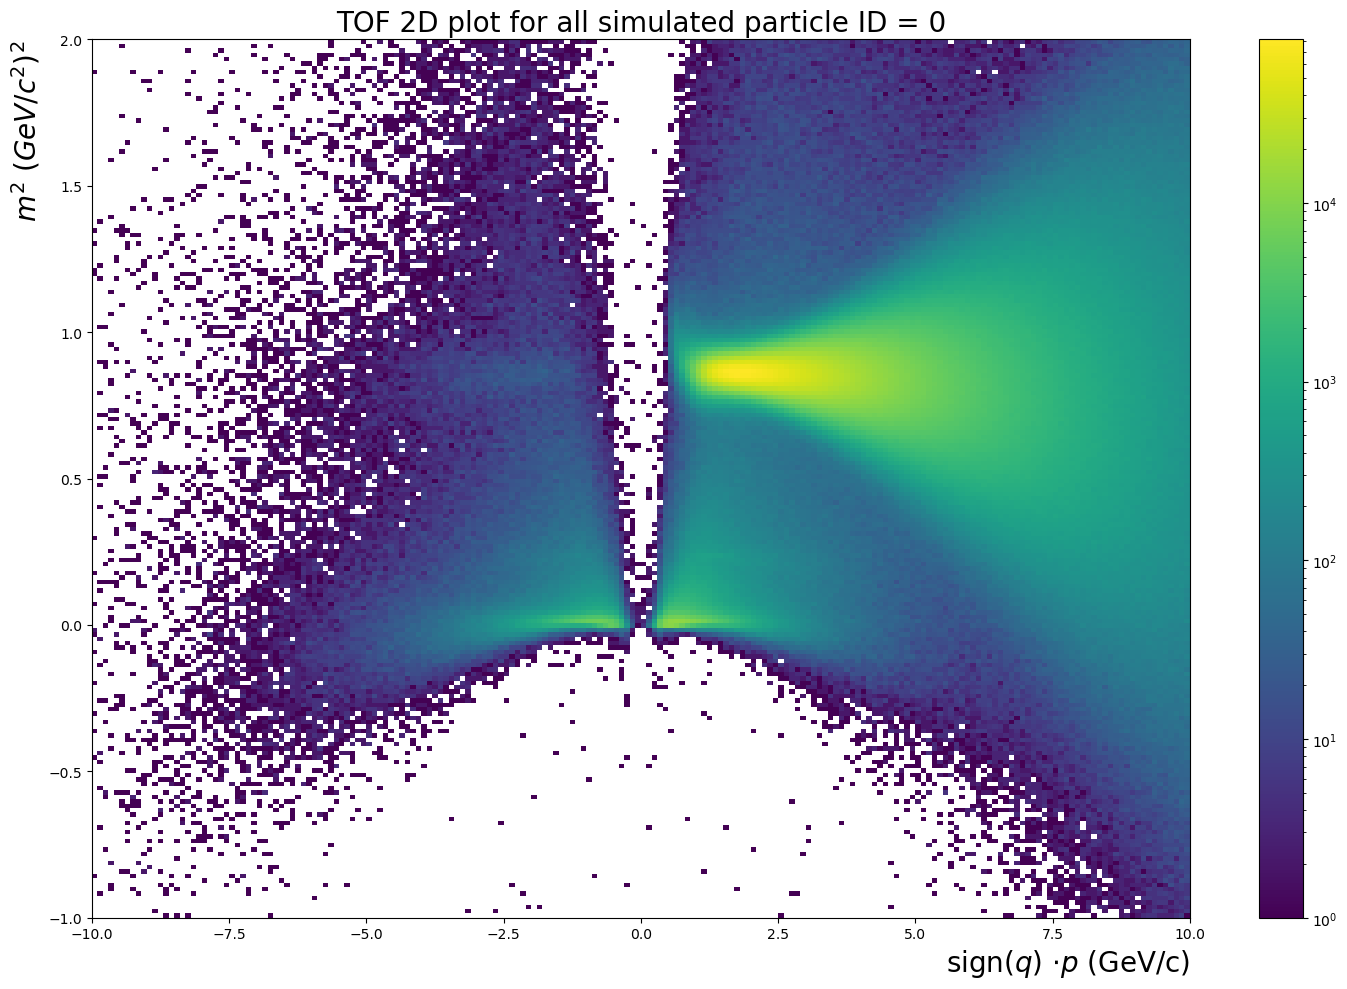

In [48]:
sim_tof(0)

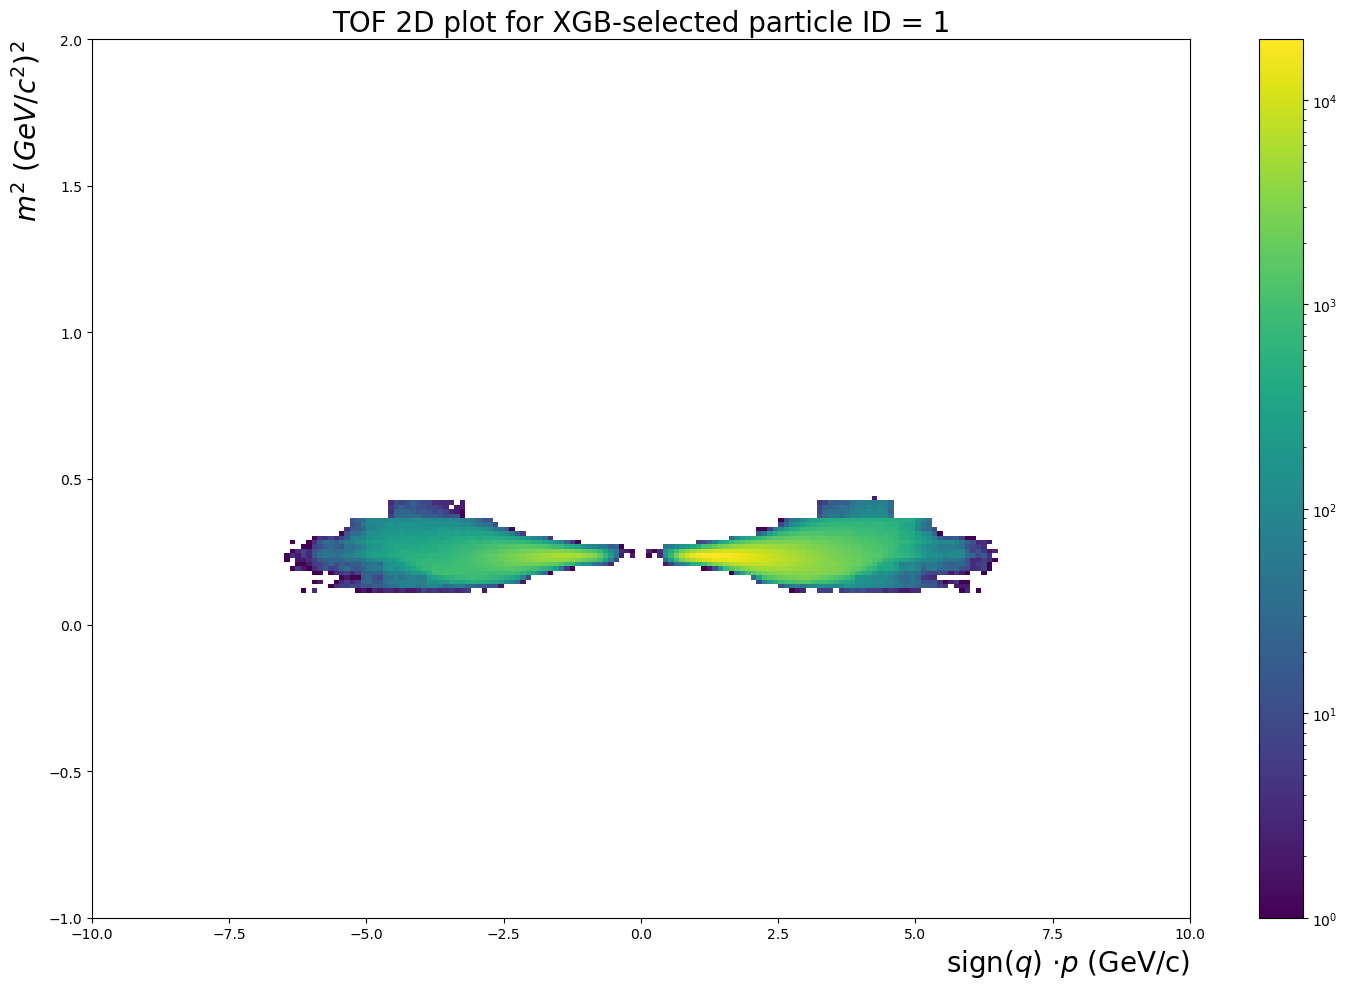

In [49]:
xgb_tof(1)

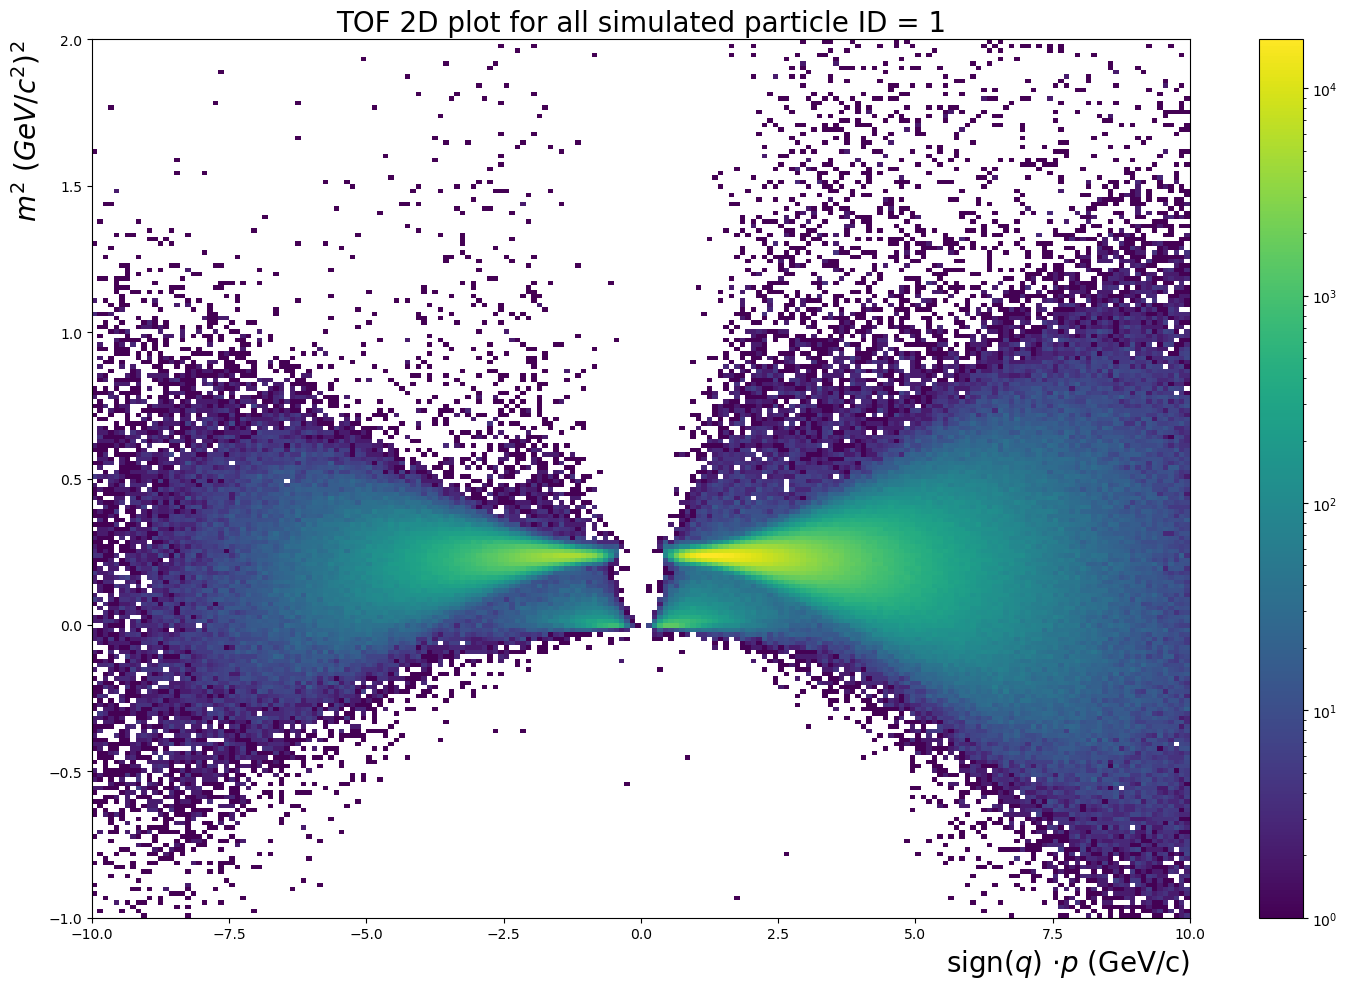

In [50]:
sim_tof(1)

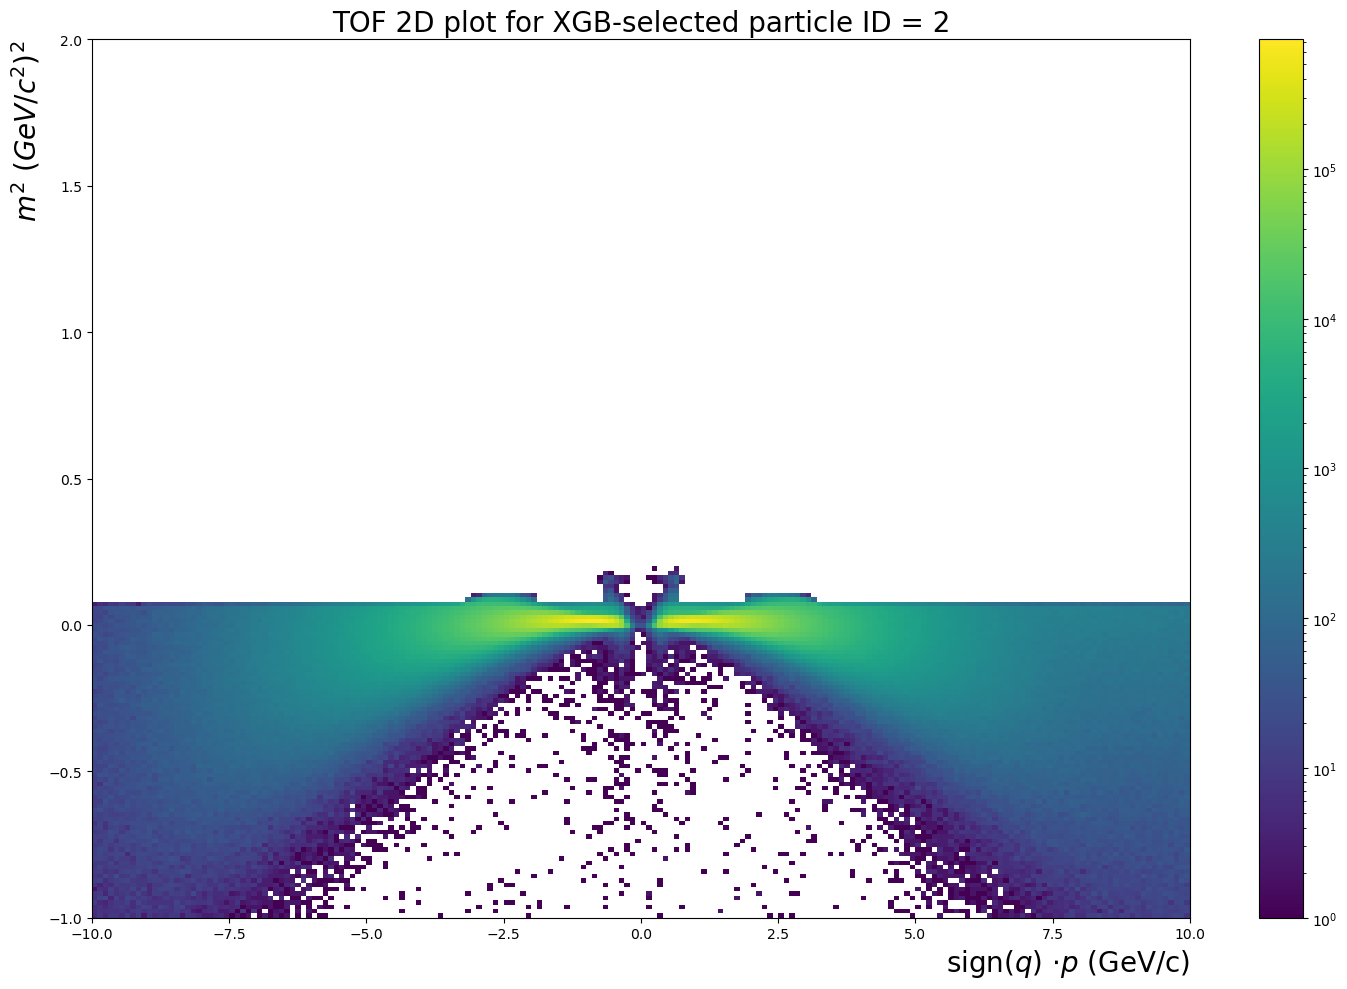

In [51]:
xgb_tof(2)

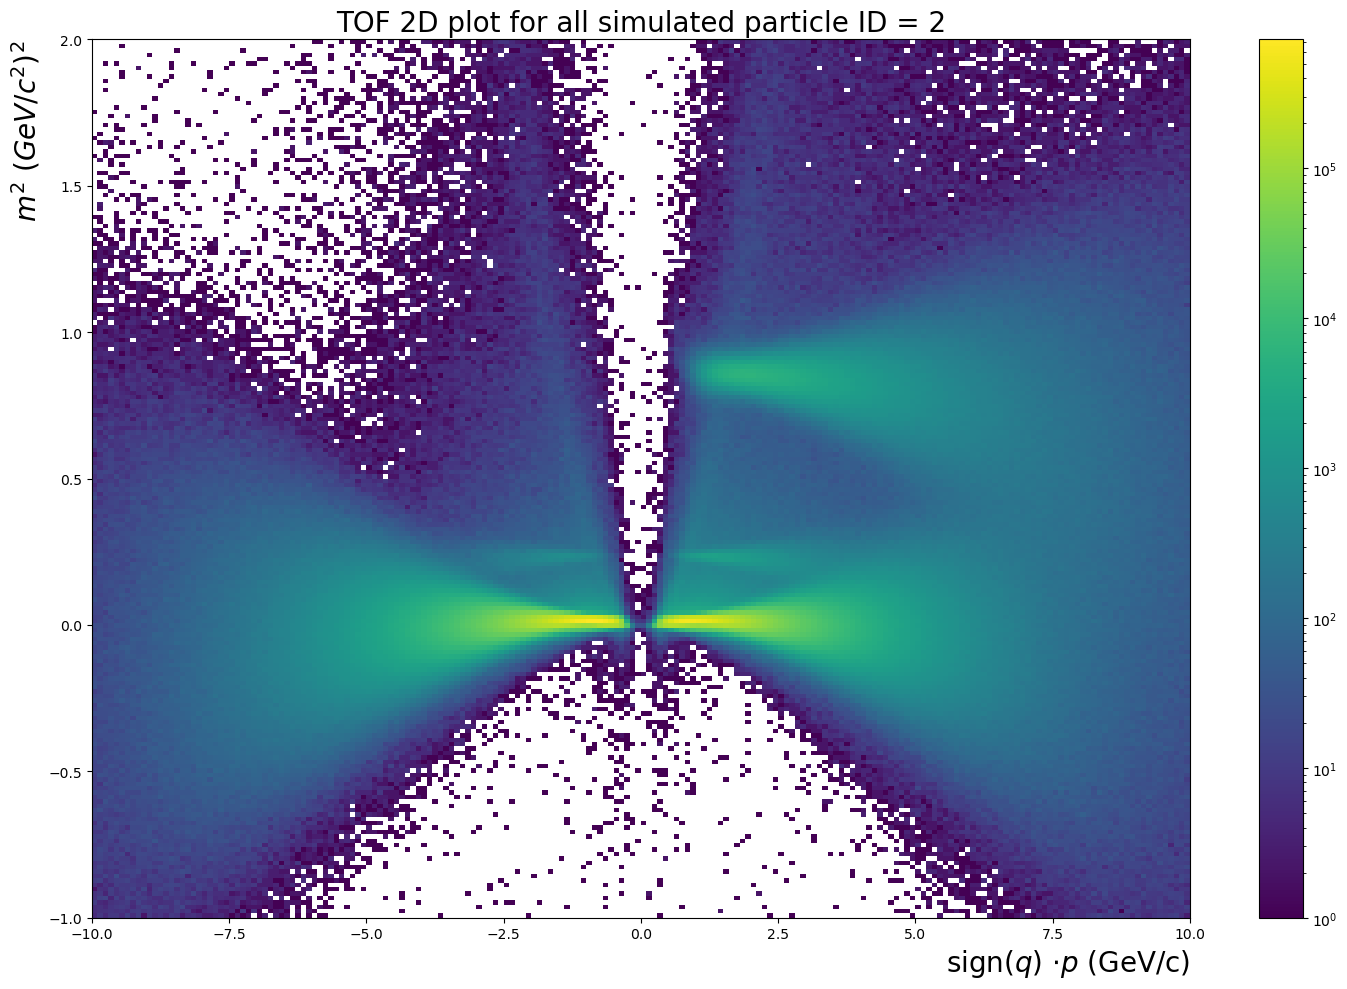

In [52]:
sim_tof(2)

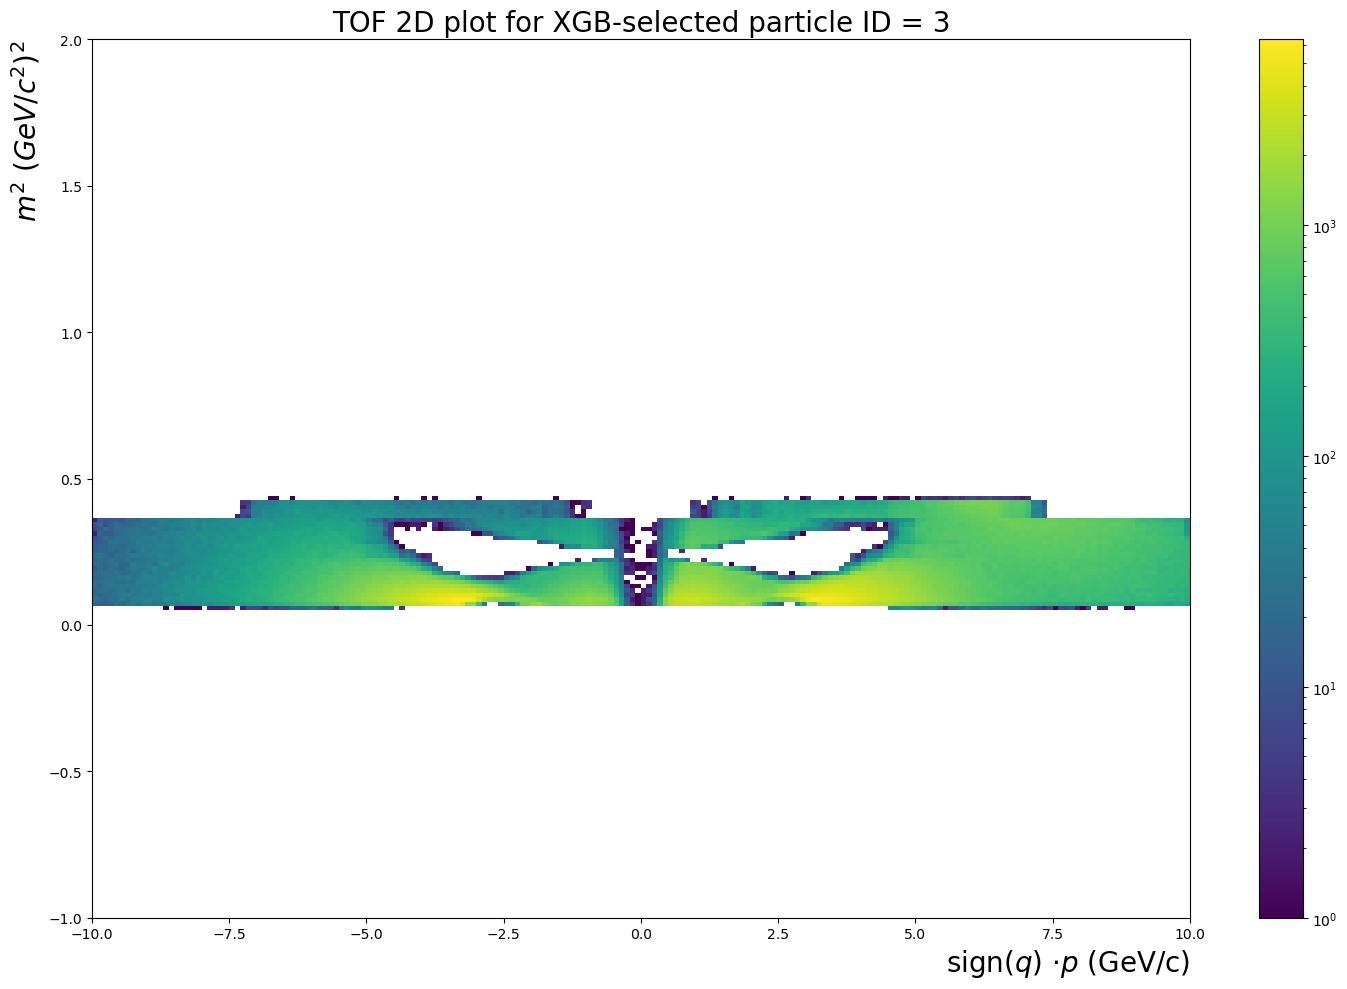

In [56]:
xgb_tof(3)

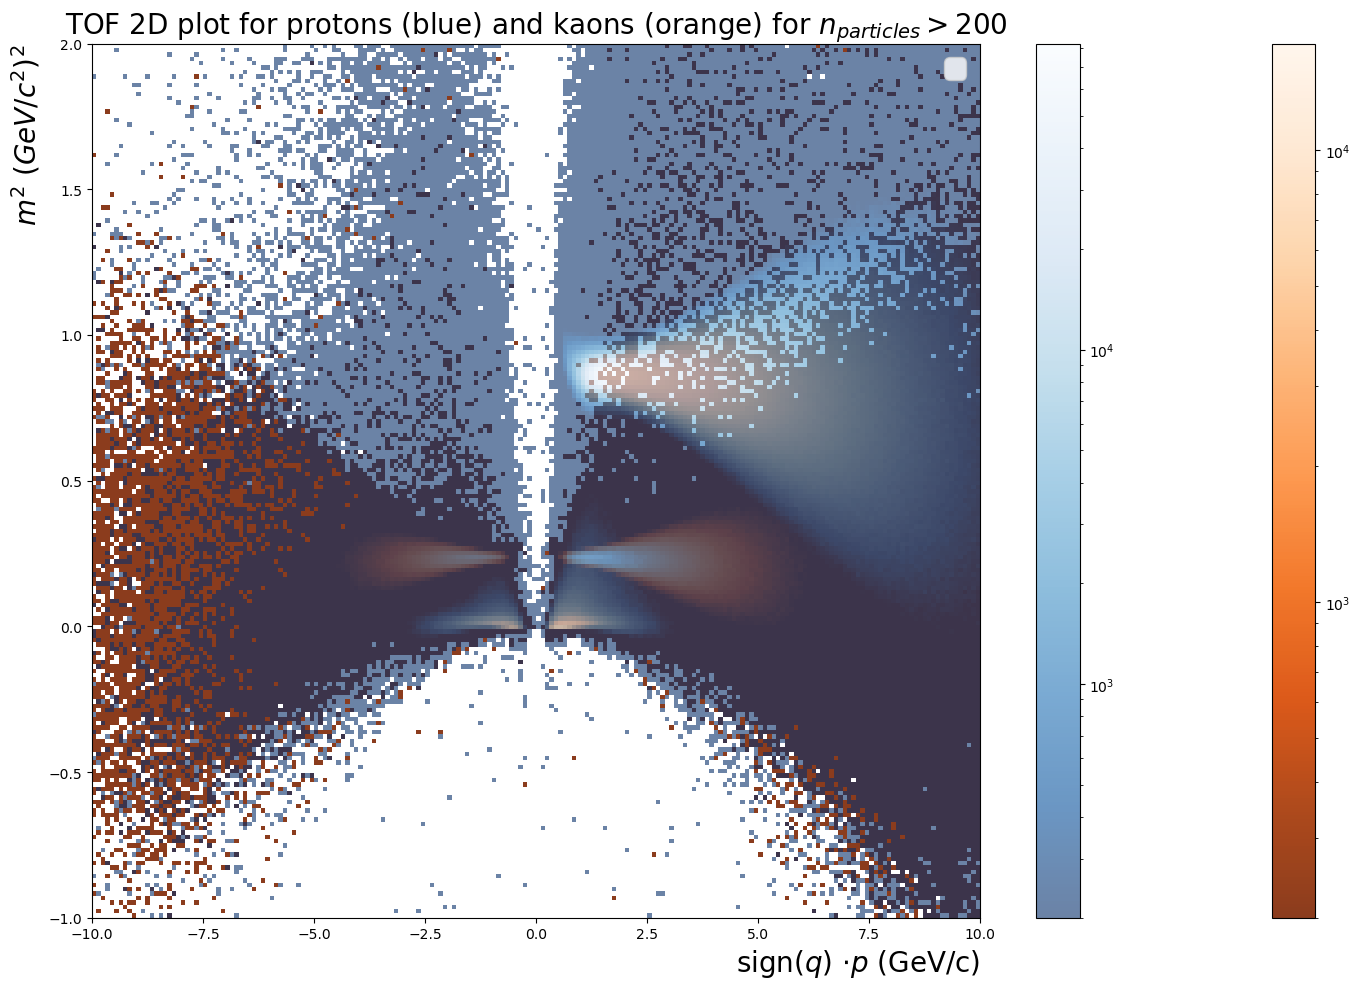

In [53]:
fig, axs = plt.subplots(figsize=(15, 10))

def subplot(pid, name, color, alpha):
    qp = particlesTest[particlesTest['pid']==pid]['q']*particlesTest[particlesTest['pid']==pid]['p']
    mass2 = particlesTest[particlesTest['pid']==pid]['mass2']
    counts, xedges, yedges, im = axs.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=200), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = alpha)
    plt.colorbar(im, ax=axs)
    # plt.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=100), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = 0.9)
ranges = [[-10, 10],[-1, 2]]
xName = r'sign($q$) $\cdot p$ (GeV/c)'
yName = r'$m^2$ $(GeV/c^2)^2$'
subplot(1, 'kaons', 'Oranges_r', .9)
subplot(0, 'protons', 'Blues_r', .6)



plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title=r'TOF 2D plot for protons (blue) and kaons (orange) for $n_{particles} > 200$'
plt.title(title, fontsize=20)
axs.legend('Classes of particles', fontsize = 20, loc='upper right')
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.show()

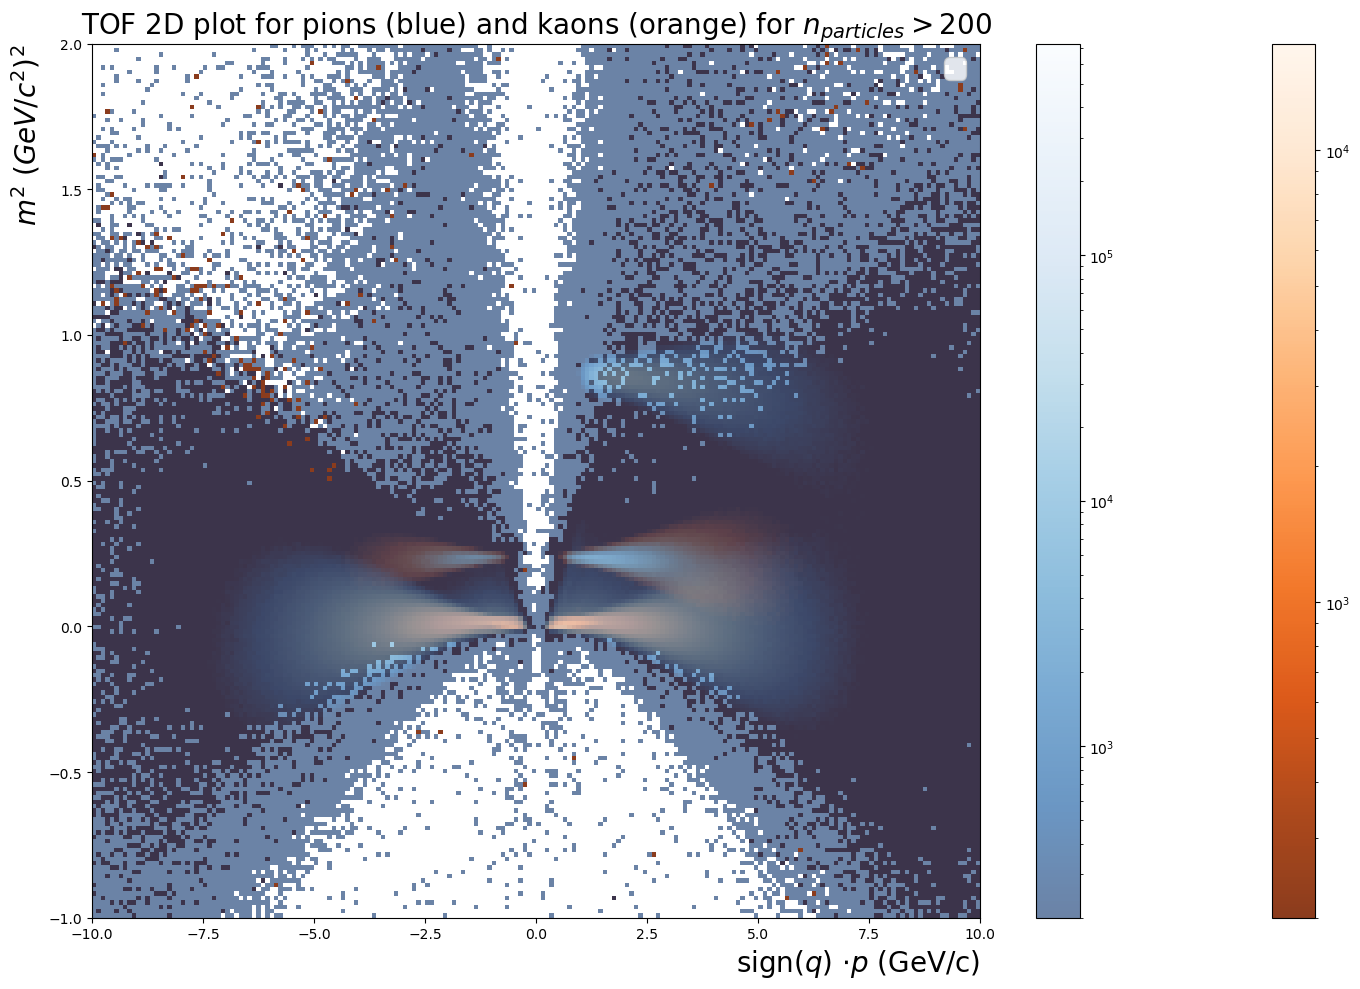

In [54]:
fig, axs = plt.subplots(figsize=(15, 10))
ranges = [[-10, 10],[-1, 2]]
def subplot(pid, name, color, alpha):
    qp = particlesTest[particlesTest['pid']==pid]['q']*particlesTest[particlesTest['pid']==pid]['p']
    mass2 = particlesTest[particlesTest['pid']==pid]['mass2']
    counts, xedges, yedges, im = axs.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=200), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = alpha)
    plt.colorbar(im, ax=axs)
    # plt.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=100), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = 0.9)

subplot(1, 'kaons', 'Oranges_r', .9)
subplot(2, 'protons', 'Blues_r', .6)



plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title=r'TOF 2D plot for pions (blue) and kaons (orange) for $n_{particles} > 200$'
plt.title(title, fontsize=20)
axs.legend('Classes of particles', fontsize = 20, loc='upper right')
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.show()